# Problem description

## Goal

Consider a dataset $\mathcal{D} = \{(\mathbf{x}_t, y_t) \}_{t=1}^N$ containing $N$ $d$ dimensional inputs, $\mathbf{x}_t \in \mathbb{R}^d$, with their corresponding outputs, $y_t \in \mathbb{R}_{\ge 0}$, ordered by time $t$. Denote the data from year 2006 and 2008 as $\mathcal{D}^{2006}$ and $\mathcal{D}^{2008}$ respectively.

We further split each of these datasets into two parts based on time. The first few weeks of each dataset is meant for training + validation, and the last few weeks are meant for testing. In some experiments, the first few weeks of data from year 2008 are not used to train any models so they are also used for testing.

Our goal is to check if the **relationship** between inputs, $\mathbf{x}_t$s, and output, $y_t$s, of the chiller has changed over time.

**Notation**
We use **bold** font to denote a vector, **bold and capitalize** font to denote a matrix, and cursive font to denote a set. E.g., $\mathbf{x}_t$ is an input vector of $d$ dimensions, $y_t$ is a positive scalar, $\mathbf{X} \in \mathbb{R}^{m \times n}$ is a matrix of shape $m \times n$, and $\mathcal{D}$ is a set.

## Approach

### Background information

1. [Structural change](https://cran.r-project.org/web/packages/strucchange/vignettes/strucchange-intro.pdf) detection.
See also [this question](https://stats.stackexchange.com/questions/355920/how-to-test-if-the-process-that-generated-a-time-series-has-changed-over-time/358144#358144) I asked on an online forum for more information on how people in statistics handle this.

2. **Change point detection** (see [ruptures package and survey](https://github.com/deepcharles/ruptures), and [Bayesian online changepoint detection](https://github.com/hildensia/bayesian_changepoint_detection)) in CS and engineering.

3. **Concept drift** (see [survey1](http://www.win.tue.nl/~mpechen/publications/pubs/Gama_ACMCS_AdaptationCD_accepted.pdf),
[survey2](https://is.muni.cz/el/1433/podzim2011/PA164/um/drift_detection_methods.pdf)).


### Further explanations and other options

1. If given continuous sequence of data, most structural change algorithm maintain a set of test statistics obtained from the data stream and check at each point in time if the test statistics has changed significantly. 

2. Train two models, one for 2006 and another for 2008 data, and test if these two models are approximately the same. This require a way to compare models directly. The Gaussian Process (GP), being a stochastic process, can be compared to one another. So an approach based on this will fit a GP to $\mathcal{D}^{2006}$ and another to $\mathcal{D}^{2008}$ and compare these two models using either the Kullback-Leibler divergence or something like ["A Kernel Independence Test for Random Processes" by Chwialkowski and Gretton](http://proceedings.mlr.press/v32/chwialkowski14.pdf)
or ["Learning from uncertain curves: The 2-Wasserstein metric for Gaussian processes" by Mallasto and Feragan](https://papers.nips.cc/paper/7149-learning-from-uncertain-curves-the-2-wasserstein-metric-for-gaussian-processes.pdf).
    
    However, as noted below, changing the hyperparameters of these models can produce different models that perform similarly on the training, validation and test data. So this method, like almost all methods listed here, will be sensitive to the settings of these hyperparameters. Ideally, we want a principled approach where we compare over all possible models (this is an important tenet of Bayesian ML).

3. Test that $\mathcal{D}^{2006}$ and $\mathcal{D}^{2008}$ are generated from the same distribution. One option is to use [Maximum Mean Discrepancy (MMD)](http://shogun-toolbox.org/notebook/latest/mmd_two_sample_testing.html) to essentially bypass the need to fit the data to a  member of a **specific family** of distribution. This is a more general version of point 2 (where a GP was used to model this distribution). The weakness of this approach is that it does not model the relationship between the $\mathbf{x}_t$ and the $y_t$ but instead tells you if the $\mathbf{x}_t$ in 2006 is "different" from those in 2008.

4. Related to 1., check the errors (predictions - actual) has changed over time given the predictions from a model trained on year 2006 data. 

Each of these methods has its weaknesses and strengths. 

## Summary of this notebook

1. We visualize the output of the chiller to visually check for any significant structure that we can exploit.
    
    - The output for each day is similar to those of other days within close few months.
    - Individual outputs (ch1kw, ch2kw, ch3kw) change between 2006 and 2008. If we have information pertaining 
      to these individual subsystems, we can do **multi-output** predictions to exploit the relationship 
      between these outputs rather than just predict their total.
    
2. We train a few algorithms/ML models to predict the output of the chiller system.
    - This tests how well regression algorithms can predict the output of chiller, i.e., we check if there is
      reason to believe the input data is related to the output.
      
3. We visualize the error of the models and observe that in general there is a change in the distribution of the error over time.

4. In general, the errors in prediction are mostly concentrated around the **time after the chillers have all shut down** (between 1130PM and 8AM).

    
## <font color="red">Warning: </font> Things to note

1. Almost all ML algorithms have hyperparameters that we need to set. **Different** hyperparameter settings can give the same training error and even validation error but very different test error.
What this says is that the same algorithm can give **very different** models but you won't know beforehand because based on the training and validation data they all look the same. But they can give very different conclusions when given the test data.

2. If the total power is **noisy**, then it does **not** make sense to consider a model **zero** error as the best model because we will be fitting the noise.

3. Extra knowledge about the structure of the problem can help improve the modeling process. For e.g., knowing when the system starts and shuts down each day (I recall paper says it shuts down around 7PM for Chinatown Point) can allow us to enforce condition that across days at the same period of time the predicted power should be close.

4. Typically we have a training set, a **validation** set, and a **test** set. It is **INCORRECT**, **UNETHICAL EVEN**, to tune your models on the test set as this is essentially fitting your model to the test data.

5. Because you are **dealing with timeseries** data, you **CANNOT** randomly select individual data points to form the training, validation and test dataset. The **REASON** is that for timeseries data, data points close in time are very similar, sometimes even close to identical, so splitting the dataset this way will likely lead to examples in the test set to be near identical to those in the training set. This is a subtle cause of **data leakage** and will give the **false impression** that the model is doing well when in reality it might be much worse.

    The **CORRECT** way ideally is to do [walk-forward validation](Walk-Forward Validation). Datasets obtained this way can be generated using [TimeSeriesSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) in a package such as [Scikit-Learn](http://scikit-learn.org/).

Furthermore, if domain knowledge about how these devices age over time (for e.g., efficiency is known to drops over time following a slow exponential curve), we can try to incorporate them into the model.

All these will enable the prediction to be more consistent and less likely to overfit to the spurious patterns in the data.

Even though Machine Learning has been marketed as a black box that is mostly automated, this is far from true in reality. There are many ways ML algorithms can overfit the data, sometimes in subtle ways, and less experienced users will be none the wiser that it has even happened.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})

import GPy
import GPyOpt

from sklearn.linear_model import Ridge, RidgeCV

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use("ggplot")
%matplotlib inline

from IPython.display import display_html
def display_side_by_side(*args):
    """Display two Pandas DataFrame side-by-side.
    Taken from https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
    """
    html_str=''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

def plot_model_error(y, pred, pred_variance=None, figsize=(21, 10), title=None):
    """Plot the groundtruth, model prediction, and model error (prediction - groundtruth)
    """
    
    index = y.index

    y = np.asarray(y).ravel()
    pred = np.asarray(pred).ravel()
    error = pred - y
    mean_error = (np.abs(error)).mean() # mean_absolute_error(y, pred)

    y = pd.Series(y, index=index)
    pred = pd.Series(pred, index=index)
    error = pd.Series(error, index=index)

    fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=figsize)

    if pred_variance is not None:
        sd = pd.Series(np.sqrt(pred_variance.squeeze()), index=index)
        axes[0].fill_between(index, pred - sd, pred + sd, alpha=0.4, color="magenta")
        
    y.plot(color="green", label="Ground truth", ax=axes[0])
    pred.plot(color="blue", alpha=0.6, label="Prediction", ax=axes[0])
    error.plot(color="red", label="Error", ax=axes[1])

    axes[1].axhline(0, color="black", linestyle="--")
    axes[0].tick_params(axis='both', which='major', labelsize=14)
    axes[1].tick_params(axis='both', which='major', labelsize=14)

    # Plot vertical lines at 8AM and 7PM
    grouped_by_day = error.groupby(index.dayofyear)
    for i, (k, g) in enumerate(grouped_by_day):
        dt_start = g.index[0].replace(hour=8, minute=0, second=0, microsecond=0)
        dt_end = dt_start.replace(hour=19)  # 1 chiller shut down at ~1900
        dt_end2 = dt_start.replace(hour=21, minute=30)  # 2 more chillers shut down at ~2130
        dt_end3 = dt_start.replace(hour=23, minute=30)  # Last chiller shut down at ~1330
        for ax in axes.ravel():
            if i == len(grouped_by_day) - 1:
                ax.axvspan(dt_start, dt_end, color="yellow", alpha=0.2, label="Daytime")
                ax.axvspan(dt_end, dt_end2, color="black", alpha=0.3, label="Shutdown-stage1")
                ax.axvspan(dt_end2, dt_end3, color="black", alpha=0.5, label="Shutdown-stage2")
                ax.axvline(dt_start, color="green", linestyle="--", label="8AM")
                ax.axvline(dt_end, color="magenta", linestyle="--", label="7PM")
                ax.axvline(dt_end2, color="red", linestyle="--", label="930PM")
                ax.axvline(dt_end3, color="black", linestyle="--", label="1130PM")
            else:
                ax.axvspan(dt_start, dt_end, color="yellow", alpha=0.2)
                ax.axvspan(dt_end, dt_end2, color="black", alpha=0.3)
                ax.axvspan(dt_end2, dt_end3, color="black", alpha=0.5)
                ax.axvline(dt_start, color="green", linestyle="--")
                ax.axvline(dt_end, color="magenta", linestyle="--")
                ax.axvline(dt_end2, color="red", linestyle="--")
                ax.axvline(dt_end3, color="black", linestyle="--")

    axes[0].legend()
    axes[1].legend()

    if title is None:
        title = "Mean error: {:.5f}".format(mean_error)
    else:
        title += " - Mean error: {:.5f}".format(mean_error)

    fig.suptitle(title, fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

def plot_cusum(y, pred, title=None, figsize=(21, 4), ax=None, **kwargs):
    """Plot cumulative error of the model"""
    
    index = y.index

    error = np.asarray(pred.ravel()) - np.asarray(y.ravel())
    error = pd.Series(error, index=index)
    cumsum = pd.Series(data=np.cumsum(error), name="CUSUM", index=index)

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig = ax.figure

    cumsum.plot(ax=ax, color="red")
    ax.axhline(0, 0, 1, color="black", linestyle="--")
    ax.tick_params(axis='both', which='major', labelsize=14)

    if title is not None:
        ax.set_title(title, fontsize=20)
    ax.legend()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

import matplotlib.ticker as ticker
def plot_outputs(df, figsize=(18, 18), title=None):
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=figsize)

    total = df.ch1kw + df.ch2kw + df.ch3kw
    max_output = total.max()
    for i, ax in enumerate(axes[:3], 1): # in range(3):
        column = "ch{}kw".format(i)
        df[column].plot(ax=ax, title="ch{}kw".format(i), label=column)
        ax.legend()

    total.plot(ax=axes[3], title="Total", label="Total output", color="blue")
    axes[3].axhline(total.mean(), linestyle="--", color="black", label="Mean")

    # Draw vertical line at 8AM and 7PM
    grouped_total_power = total.groupby(total.index.dayofyear)
    for i, (k, g) in enumerate(grouped_total_power):
        dt = g.index[0]
        dt_start = dt.replace(hour=8, minute=0, second=0, microsecond=0)
        dt_end = dt.replace(hour=19, minute=0, second=0, microsecond=0)
        if i == len(grouped_total_power) - 1:
            axes[3].axvline(dt_start, color='green', linestyle='--', label="8AM")
            axes[3].axvline(dt_end, color='red', linestyle='--', label="7PM")
        else:
            axes[3].axvline(dt_start, color='green', linestyle='--')
            axes[3].axvline(dt_end, color='red', linestyle='--')

    tick_spacing = 50
    axes[3].yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    axes[3].legend()

    if title is not None:
        fig.suptitle(title)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Setup

## Global parameters

In [2]:
N_TIMESERIES_SPLITS = 5
BO_RAND_STATE = 777
SCORE_TYPE = "neg_mean_absolute_error"

## Get data 

Note that the data have been preprocessed earlier in another Jupyter notebook to remove entries with missing data (indicated as "\\N" in csv file). This is why there are some gaps in the observations shown in the plots below.

In [34]:
df1 = pd.read_csv("../data/insead_2016_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")
df2 = pd.read_csv("../data/insead_2018_no_missing.csv.gz", index_col="timestamp",
                 parse_dates=["timestamp"], compression="gzip")

display_side_by_side(df1.head(2), df2.head(2))

chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 ch1kw 
 ch2kw 
 ch3kw 
 loadsys 
 chwsfhdr 
 ch1_status 
 ch2_status 
 ch3_status 
 totalkw 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2016-02-01 00:00:00 
 0.00000 
 30.4664 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0.000 
 0 
 0 
 0 
 0.000 
 
 
 2016-02-01 00:01:00 
 8.46289 
 30.3218 
 27.143 
 536.522 
 0.844 
 0.856 
 82.944 
 113.924 
 407.278 
 0 
 0 
 1 
 84.644 
 
 
 
 
 
 
 chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 ch1kw 
 ch2kw 
 ch3kw 
 loadsys 
 chwsfhdr 
 ch1_status 
 ch2_status 
 ch3_status 
 totalkw 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 2018-04-01 00:00:00 
 0.0000 
 0.0000 
 0.0000 
 576.223 
 42.24 
 0.848 
 0 
 95.6832 
 486.972 
 1 
 0 
 0 
 43.088 
 
 
 2018-04-01 00:01:00 
 10.7674 
 28.8237 
 26.3996 
 579.979 
 42.24 
 0.852 
 0 
 96.2943 
 486.091 
 1 
 0 
 0 
 43.092

In [35]:
df1.shape, df2.shape

((81623, 13), (53147, 13))

## Separate into feature and target

In [36]:
features = [
"chwshdr",
"cwrhdr",
"cwshdr",
"cwsfhdr",
"loadsys",
"chwsfhdr", 
]

status_features = [
"ch1_status",
"ch2_status",
"ch3_status"    
]

target = ["totalkw"]

In [37]:
# Assign features and targets
y1 = df1.totalkw
y2 = df2.totalkw
X1 = df1[features]
X2 = df2[features]

## Split into train and test data

Let's count the number of data points we have per week of each year.

In [7]:
# Number of days in each week in the two datasets
display_side_by_side(df1.groupby(df1.index.week).size().to_frame(name="Number of examples per week (2006)"),
                     df2.groupby(df2.index.week).size().to_frame(name="Number of examples per week (2008)"))

Number of examples per week (2006) 
 
 
 timestamp 
 
 
 
 
 
 5 
 10065 
 
 
 6 
 10046 
 
 
 7 
 10062 
 
 
 8 
 6247 
 
 
 9 
 9710 
 
 
 10 
 9746 
 
 
 11 
 9930 
 
 
 12 
 10066 
 
 
 13 
 5751 
 
 
 
 
 
 
 Number of examples per week (2008) 
 
 
 timestamp 
 
 
 
 
 
 13 
 1437 
 
 
 14 
 10049 
 
 
 15 
 10058 
 
 
 16 
 10059 
 
 
 17 
 10054 
 
 
 18 
 10054 
 
 
 19 
 1436

Then we split each dataset into two parts. The first contain the **first 4 weeks**, and the second contain the rest.
We also show the number of examples in each resulting dataset.

In [38]:
N_TRAIN_WEEKS = 4  # First few weeks are used for training, rest for test.

X1_train = X1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
X1_test = X1.iloc[X1.index.week > X1_train.index.week[-1]]

y1_train = y1.iloc[X1.index.week < X1.index.week[0] + N_TRAIN_WEEKS]
y1_test = y1.iloc[X1.index.week > X1_train.index.week[-1]]

X2_train = X2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
X2_test = X2.iloc[X2.index.week > X2_train.index.week[-1]]

y2_train = y2.iloc[X2.index.week < X2.index.week[0] + N_TRAIN_WEEKS]
y2_test = y2.iloc[X2.index.week > X2_train.index.week[-1]]

dataset_counts = pd.DataFrame(((name, len(x))
     for x, name in zip((X1_train, X1_test, X2_train,
                         X2_test), ("Train (2006)", "Test (2006)",
                                    "Train (2008)", "Test (2008)"))))
dataset_counts.set_index(0).T

0  Train (2006)  Test (2006)  Train (2008)  Test (2008)
1         36420        45203         31603        21544

## Visualize output of chiller

Let's visualize the output for the dataset from year **2006**.

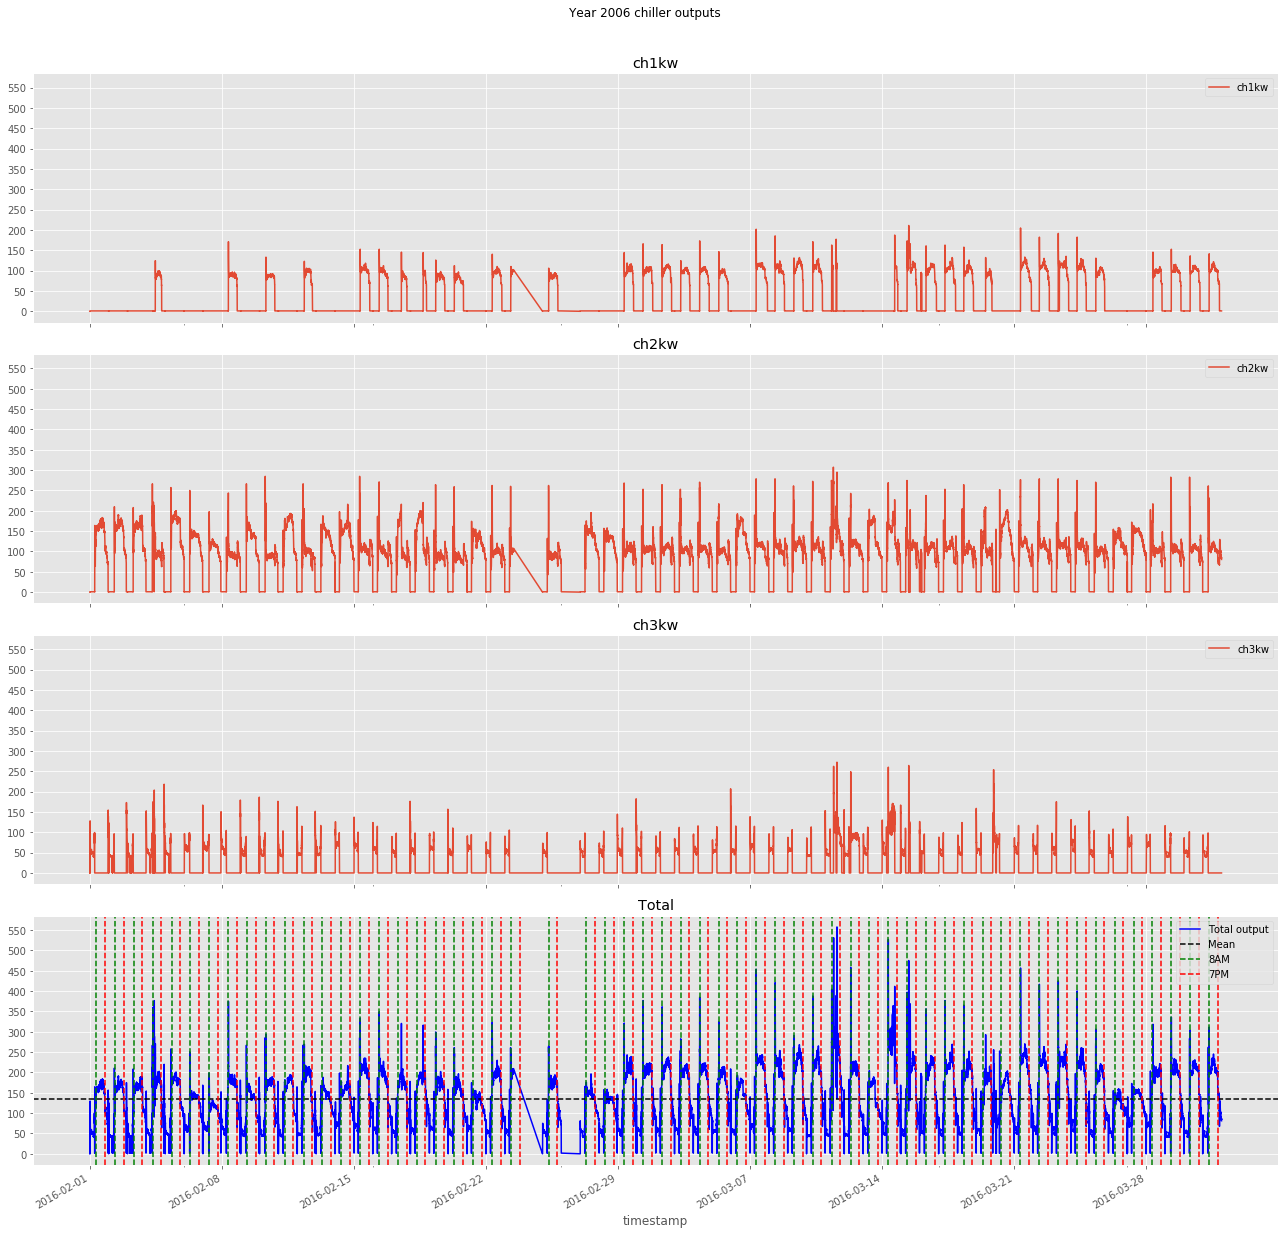

In [9]:
plot_outputs(df1, title="Year 2006 chiller outputs")

Next, we visualize the output for the dataset from year **2008**.

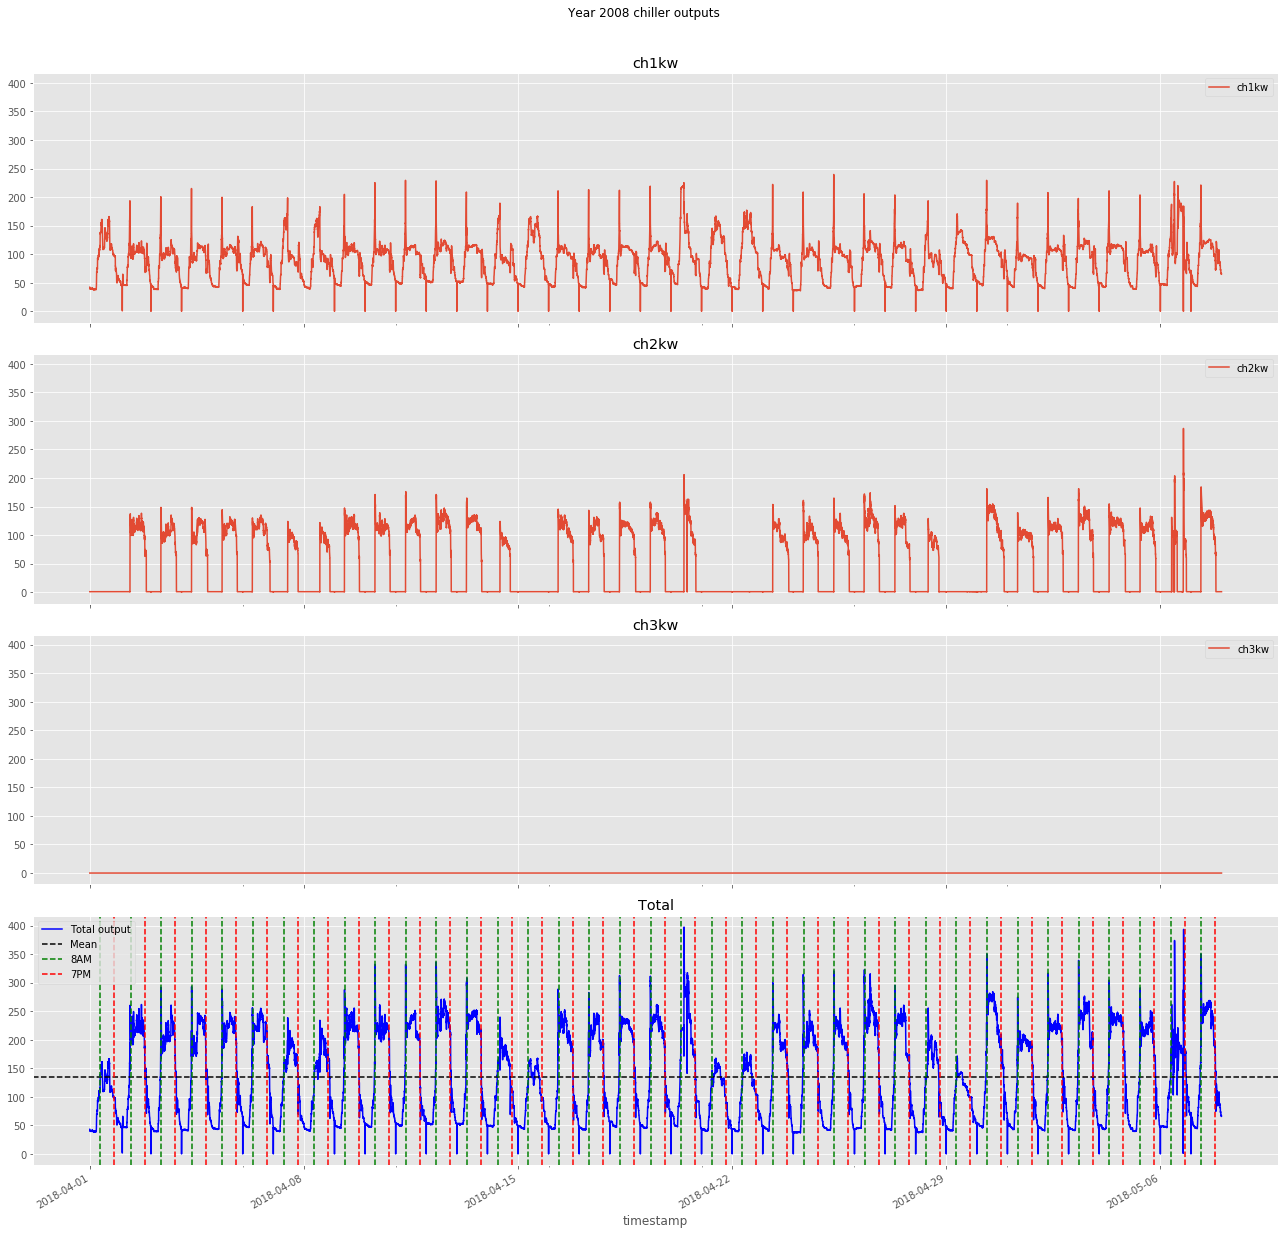

In [10]:
plot_outputs(df2, title="Year 2008 chiller outputs")

It is worth noting that pattern does not only change in the total, but also in the individual outputs "ch1kw", "ch2kw" and "ch3kw".

The mean total power is roughly the same (slightly less than 150) for both years, but the **peak daily total power** seems to be much higher in 2006's data. 

Could this be due to
1. Aging equipment,
2. data being collected on different month and year (temperature different) and/or
3. changes in system configuration?

Note: this [weather map](http://www.weather.gov.sg/climate-detailed-view/) of Singapore suggests that it was **much hotter in April 2008 than February 2006**.

There is a chunk of consecutive missing data in 2006. There should also be some missing data in 2008, but these are sporadic, and is less of a problem. In general this is a problem only for models that model the data as sequence. 

Lastly note that the range of the x-axis for the 2006 and 2008 datasets are different when trying to compare the plots for these two years.

---

# Build models

Here we train various models on data from the first few weeks of the dataset from year **2006** to predict the total output of the chiller. Each of these model represents the relationship between the given inputs and outputs in year 2006. 

We will use these models to predict the output given the data in year 2006 (later part) **and** 2008 and check if the error of prediction follows a different pattern for the two years.

Intuitively, we are checking for the following cases

1. Errors in 2006 and 2008 do not differ by much, i.e., chiller has not changed/aged.
2. Predictions generally **larger** than recorded output (over prediction).
3. Predictions generally **smaller** than recorded output (under prediction).
4. Sporadic large errors (anomalies).

The hyperparameters are selected using [Bayesian Optimization](https://en.wikipedia.org/wiki/Bayesian_optimization) to maximize the performance using **timeseries-based cross validation**.

Finally, we test the the models on both the training and test datasets.

**Note**:
Models have hyperparameters and different hyperparameters may result in different models with same training error but different test error. Therefore this approach in general can be sensitive to how the hyperparameters are set and **can lead to different conclusion** about the state of the chiller. This is why it was mentioned earlier that this approach might not be a good one.

## Ridge regression

This is linear regression with $L_2$ regularization, otherwise known as ridge regression.

Essentially we are finding for $\lambda > 0$

$
\underset{\mathbf{w}}{\text{argmin}} \sum_{t = 0}^N \lvert\lvert \mathbf{w}^T \mathbf{x}_t - y_t \rvert\rvert^2_2 + \lambda \lvert\lvert \mathbf{w} \rvert\rvert^2
$

It is pretty much **always** the case that you models have some way to control model complexity. Quoting a famous ML researcher, using linear regression **without** regularization is like driving without wearing selt belts. Basically it is wrong.

We want to test how well a simple ridge regression model can predict the output given the input data. We use Bayesian Optimization to find the best set of hyperparameters that minimizes the **walk-forward crossvalidated mean absolute error (MAE)**.

Best alpha param: 0.001


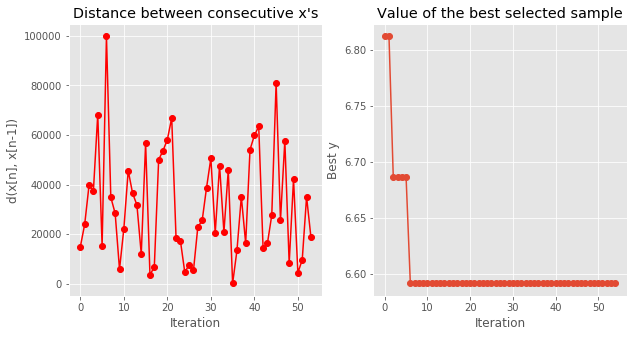

In [11]:
# Set up Bayesian Optimization
import functools

def f_lr(params, X, y, cv):
    params = params[0]
    score = -cross_val_score(Ridge(alpha=params[0]),                              
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_lr, X=X1_train, y=y1_train, cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
lr_domains = [{'name': 'alpha', 'type': 'continuous', 'domain': (1e-3, 1e5)}]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=lr_domains,
                                                acquisition_type='EI', # "LCB" works better
                                                acquisition_par=0.2,
                                                exact_feval=False)
optimizer.run_optimization(max_iter=50)
print("Best alpha param: {}".format(optimizer.x_opt[0]))

optimizer.plot_convergence()

### Plot errors

Note that 2006 (early part) is also the **training** data.

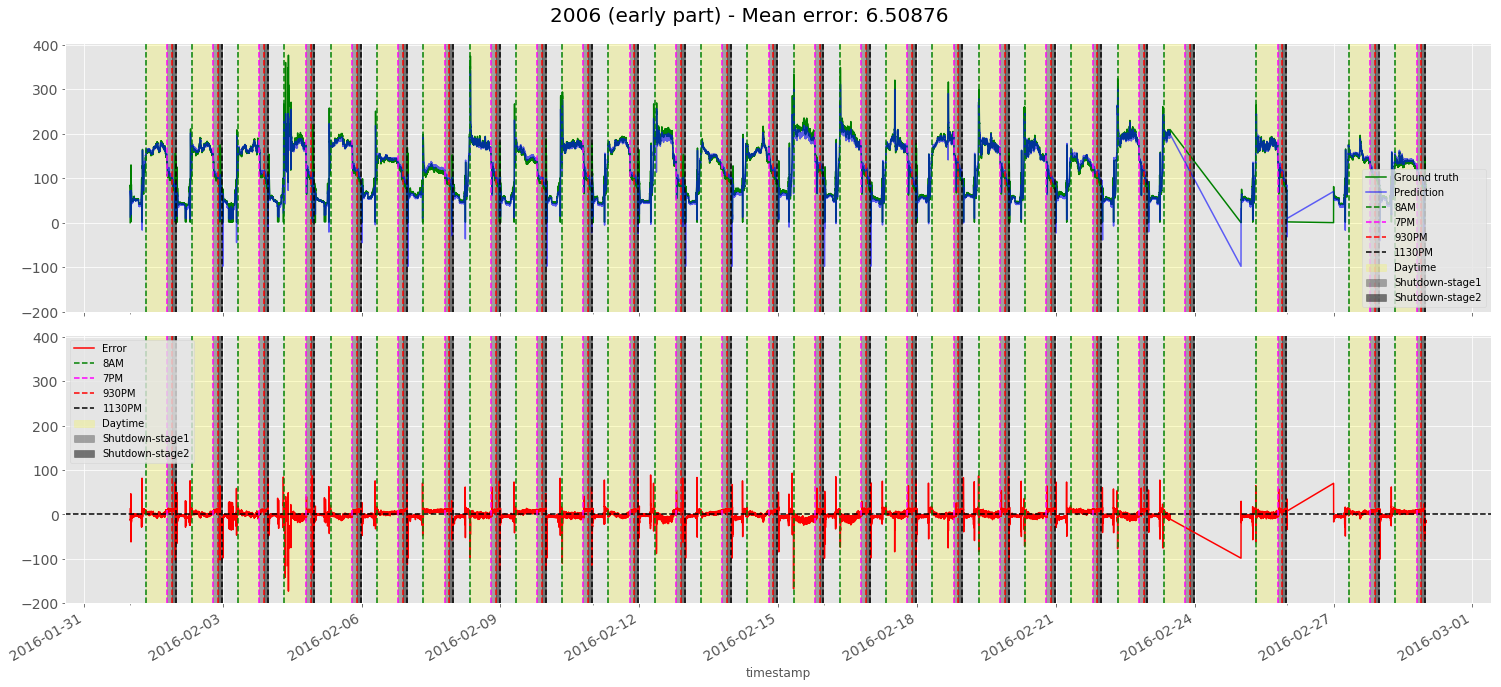

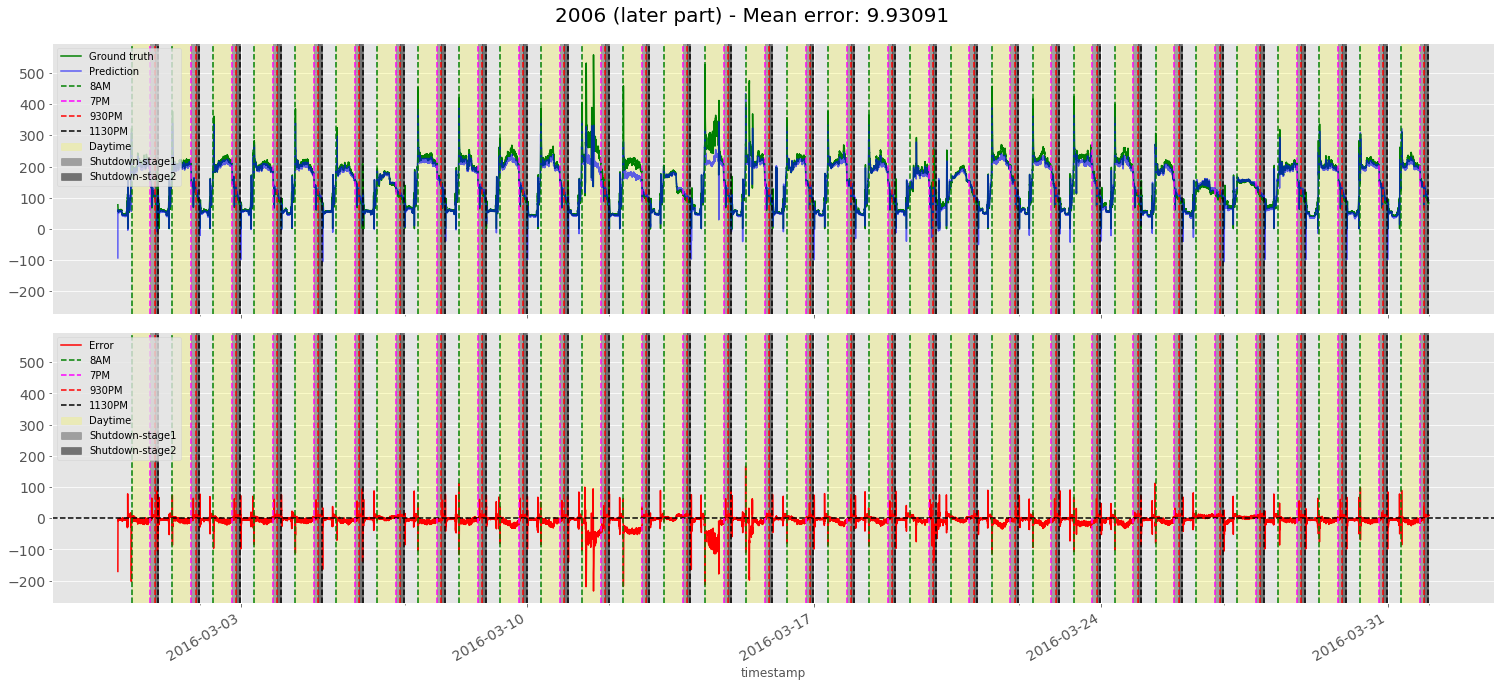

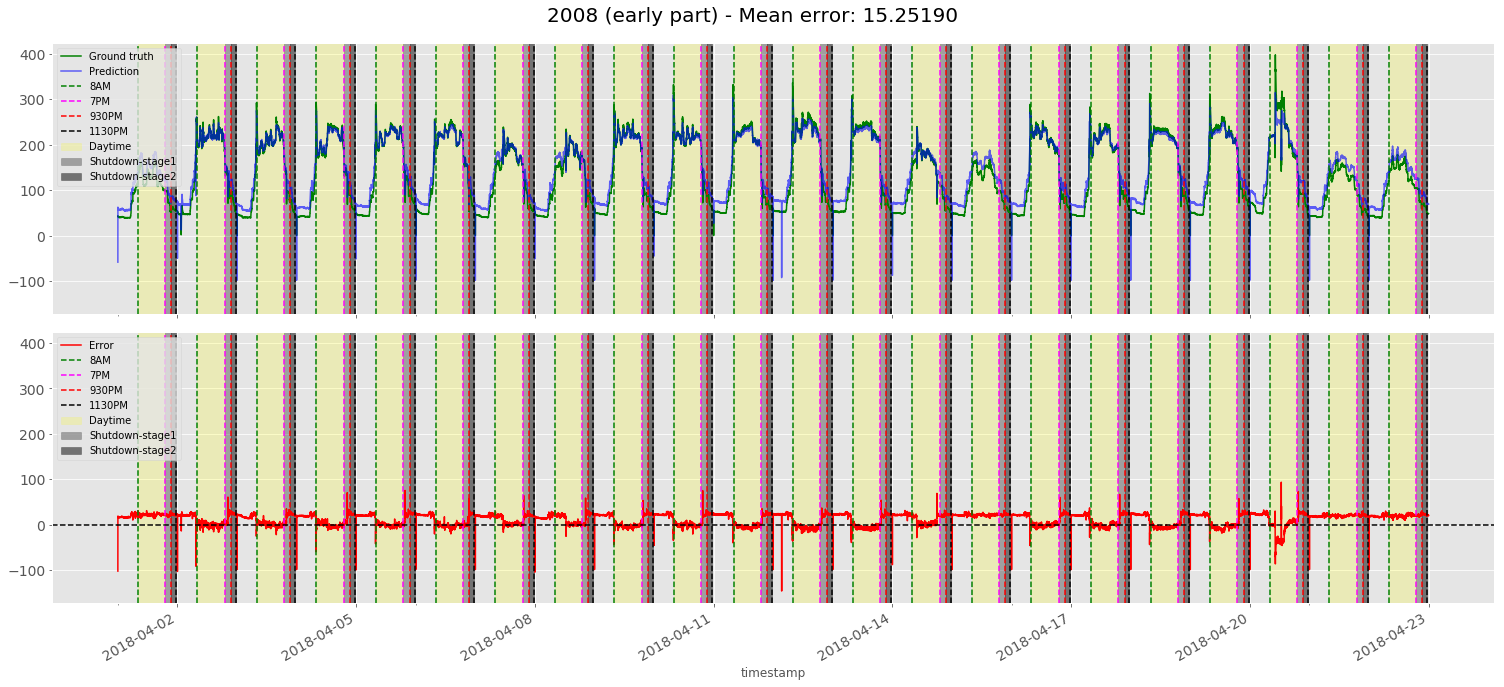

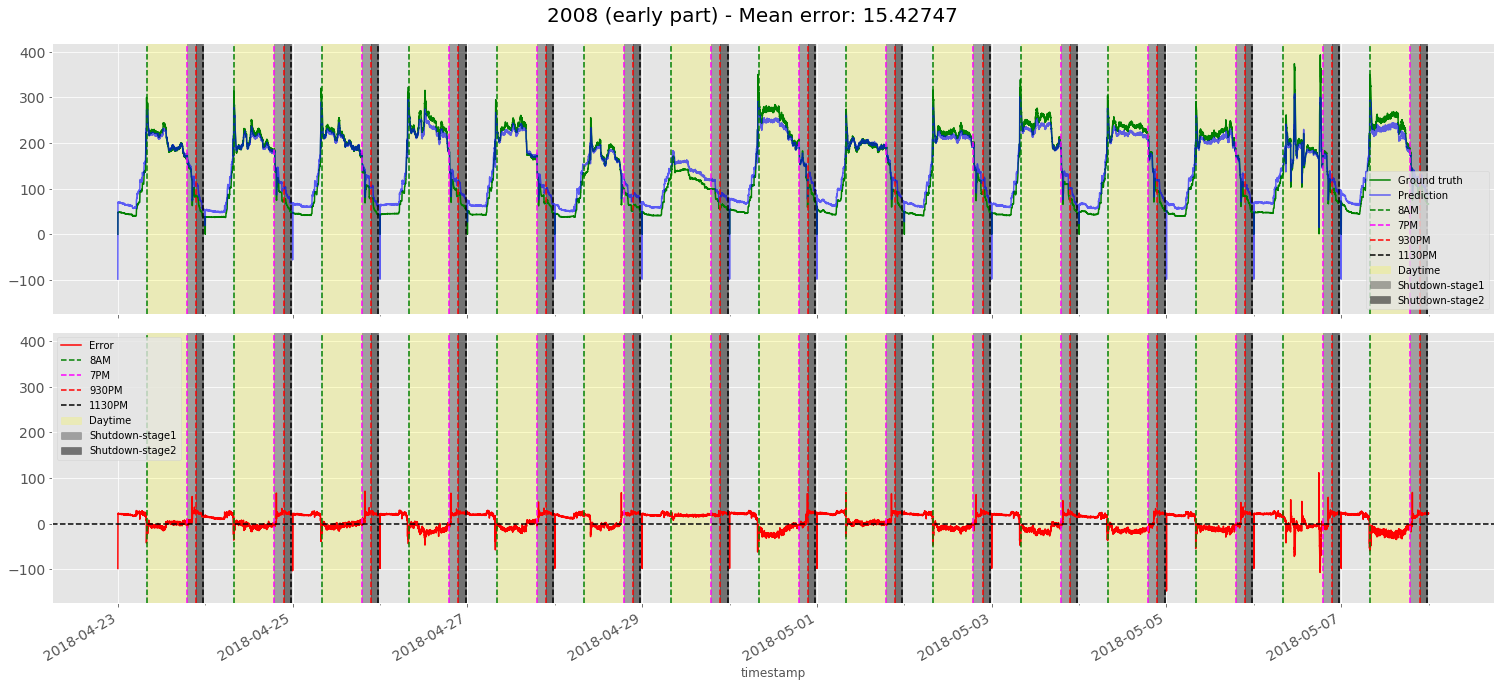

In [96]:
lr = Ridge(alpha=optimizer.x_opt[0])
lr.fit(X1_train, y1_train)

y1_train_pred = lr.predict(X1_train)
y2_train_pred = lr.predict(X2_train)

y1_test_pred = lr.predict(X1_test)
y2_test_pred = lr.predict(X2_test)

plot_model_error(y1_train, y1_train_pred, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2008 (early part)")

Prediction by model is in <font color="blue">**blue**</font>, actual is <font color="green">**green**</font>. Their difference, i.e, error = prediction - actual, is in <font color="red">**red**</font> at the bottom.

The timestamp at the bottom is set for **12AM**. E.g., 2018-04-23 is 23rd April 2018 12AM, and the first yellow region from the left is the period when all the chillers are operating for this day.

The colored dotted vertical lines correspond to time **8AM** (<font color="green">**Green**</font>), **7PM** (<font color="magenta">**magenta**</font>),  **930PM** (<font color="red">**red**</font>), and **1130PM** (<font color="black">**black**</font>). These times are taken from the paper "Energy Optimization of an In-Service Building Chiller Plant via Extremum Seeking Control" by Vu et al. and correspond respectively to start up, 2 chillers shutdown, 1 more chiller shutdown, and finally last chiller shutdown for Chinatown Point (CPT).

**Note: The timing given in the paper is for 4 chillers but our dataset is for a system with only 3 chillers**. But based on the plots we see that these times are associated with visible changes in the output.

Furthermore, the paper above mentioned that chiller is on from 9AM to 1PM on Saturdays. This is **not** explicitly marked out in the diagrams above and below.


**Key observations**:

Most of the **errors occur near the startup and after the first 2 chillers shutdown after 7PM**. 

Strangely **even after the final chiller shutdown at 1130PM there is still power**.

We see that this model in general **under predicts in the region after 7PM (grey)** for the year 2006 test data (top) and **over predicts** for both parts of the year 2008 data (middle 2 and bottom 2 figures) for this same time period.

The system is not modeling these cases well, and having extra information (i.e., extra inputs or knowledge from logs) that we can use to build more sophisticated models will help in reducing errors in such cases.

### Plot cumulative error

Here we plot the cumulative error over time. This is just the cumulative sum of the error plots (red lines) above. In general, **if there is no systemic over/under prediction, the cumulative error should even out over the long run so it should stay near 0**. This is essentially the main idea behind some structural change algorithms.

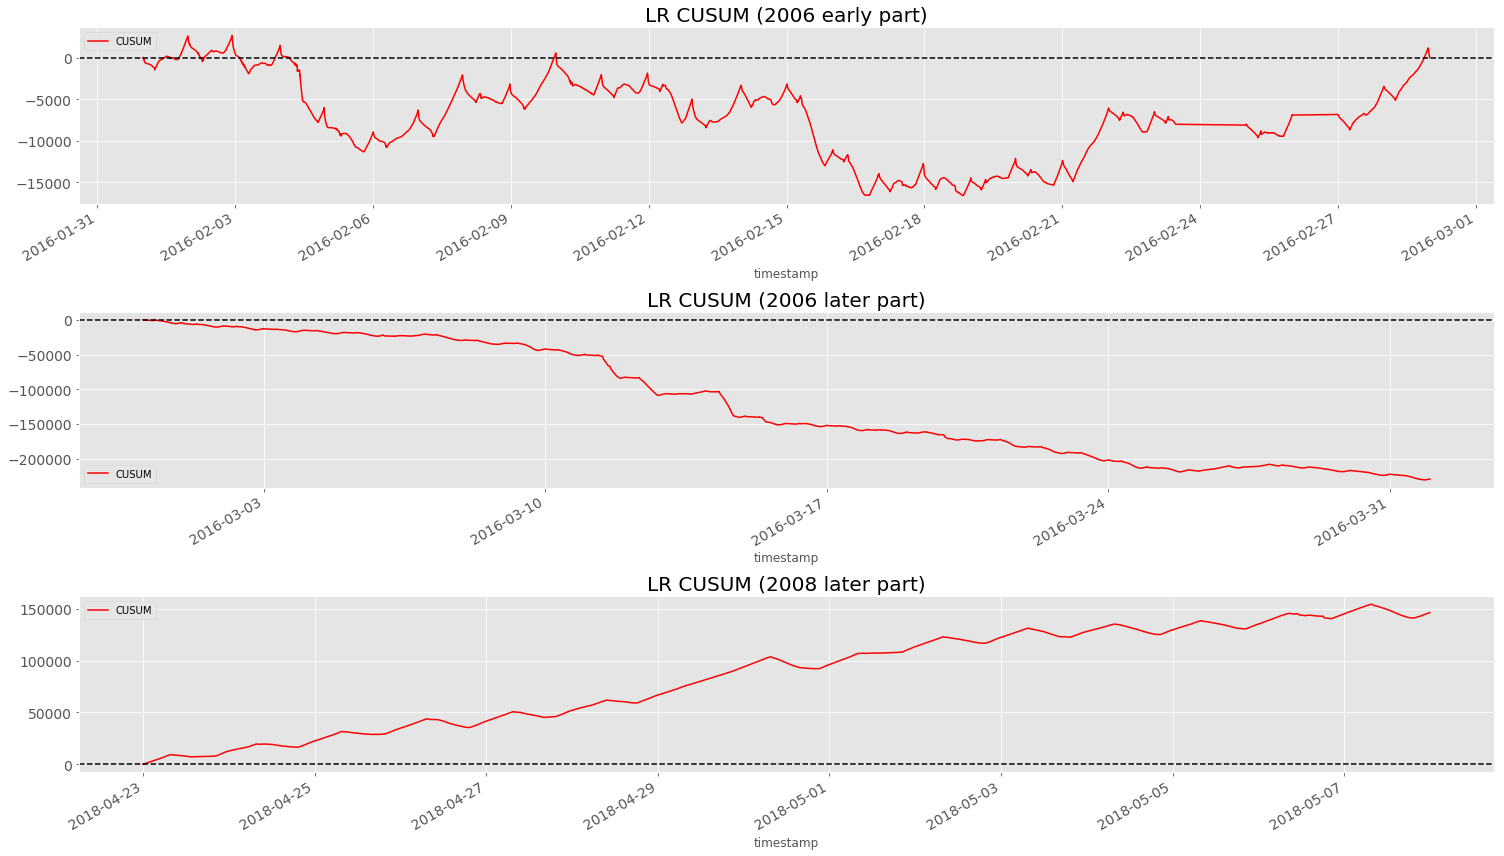

In [53]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "LR CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "LR CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "LR CUSUM (2008 later part)", ax=axes[2])

We see that when tested on the **training** data, the cumulative error eventually goes back to 0 (dotted line), although it seems to be under predicting in general.

When tested on data **not** used in training, the model is clearly **under predicting** for the later part of year 2006 data and **over predicting** for both parts of year 2008 data. You can verify this from the error plots in figures earlier.

**What this means** is that even for data from the same year, this model will lead to a conclusion that there are changes in the system. This is clearly a problem.

## XGBoost

Here we perform the same experiments as above but with the popular XGBoost regressor. This is a tree-based regressor. In general, it is a "high capacity" model unlike ridge regression and should give better results than ridge regression.

Best param: [  0.6        516.54779036  12.        ]


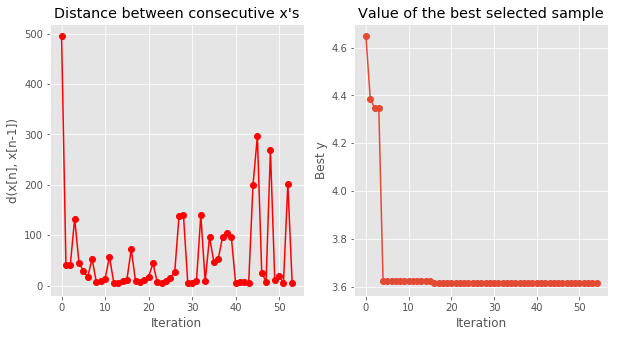

In [140]:
from xgboost import XGBRegressor

xgb_domains = [
#     {
#         "name": "learning_rate",
#         "type": "continuous",
#         "domain": (1e-5, 1)
#     },
#     {
#         'name': 'gamma',
#         'type': 'continuous',
#         'domain': (0, 5)
#     },
    {
        "name": "colsample_bytree",
        "type": "continuous",
        "domain": (0.3, 0.6)
    },
    {
        "name": "reg_lambda",
        "type": "continuous",
        "domain": (0.1, 1e3)
    },
#     {
#         "name": "reg_alpha",
#         "type": "continuous",
#         "domain": (0, 1e3)
#     },
    {
        "name": "max_depth",
        "type": "discrete",
        "domain": (7, 12)
    },
#     {
#         "name": "n_estimators",
#         "type": "discrete",
#         "domain": (100, 500)
#     }
]

def f_xgb(params, X, y, cv, random_state):
    params = params[0]
    score = -cross_val_score(XGBRegressor(
                                          n_estimators=200,
                                          max_depth=int(params[2]),
#                                           learning_rate=params[0],                                          
#                                           gamma=params[1],
                                          learning_rate=0.1,
                                          colsample_bytree=params[0],
                                          reg_lambda=params[1],
#                                           reg_alpha=params[4],
                                          random_state=random_state,
                                          n_jobs=4
                                          ),
                             X, y,
                             cv=cv,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)

np.random.seed(BO_RAND_STATE)
random_state = 1234
f = functools.partial(f_xgb, X=X1_train, y=y1_train, 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS),
                      random_state=random_state)

optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=xgb_domains,
                                                acquisition_type='EI', # "LCB" sometimes work better
                                                acquisition_par=0.2,
                                                exact_feval=False)


optimizer.run_optimization(max_iter=50)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()

In [141]:
params = optimizer.x_opt
xgb = XGBRegressor(n_estimators=200,
                   max_depth=int(params[2]),
                   learning_rate=0.1,                                      
                   colsample_bytree=params[0],
                   reg_lambda=params[1],
#                    reg_alpha=params[4],
                   random_state=random_state,
                   n_jobs=4)

xgb.fit(X1_train, y1_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=1234,
       reg_alpha=0, reg_lambda=516.547790360732, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### Plot errors

Note that 2006 (early part) is also the **training** data.

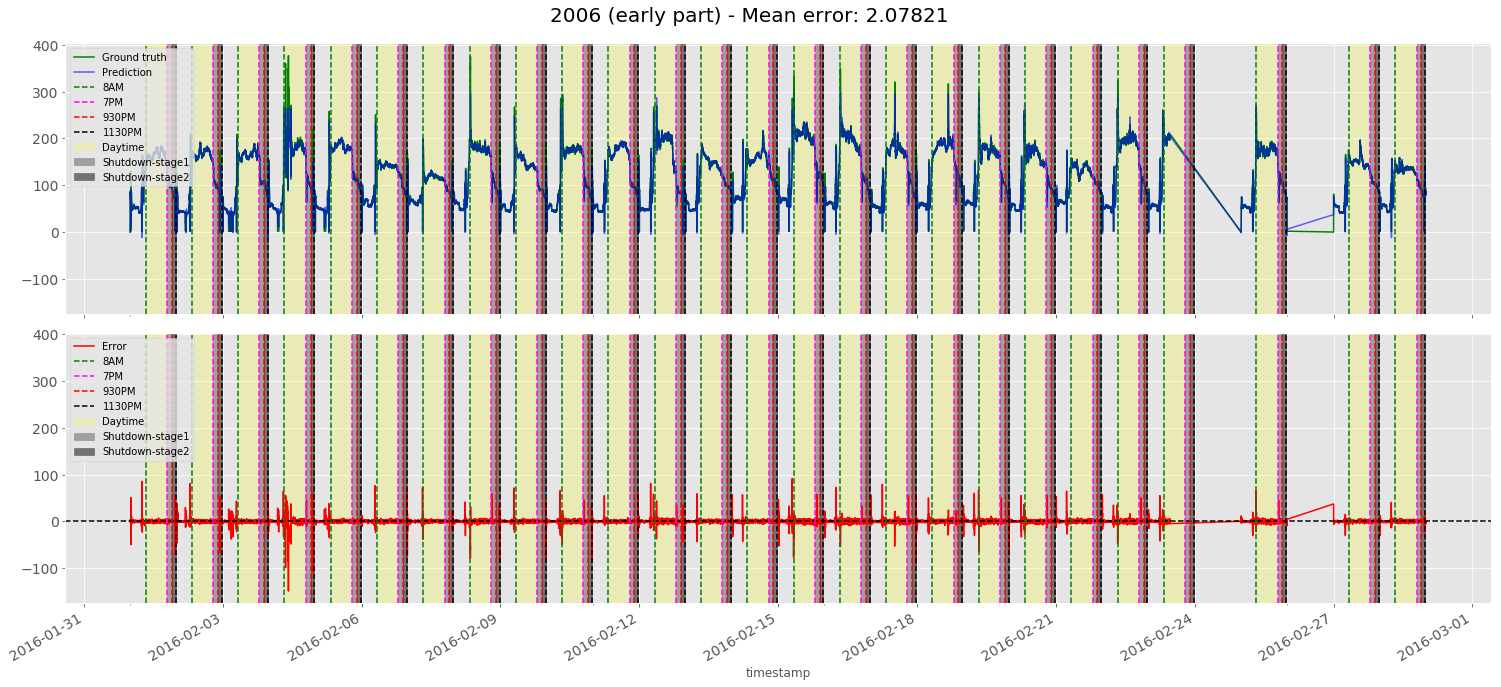

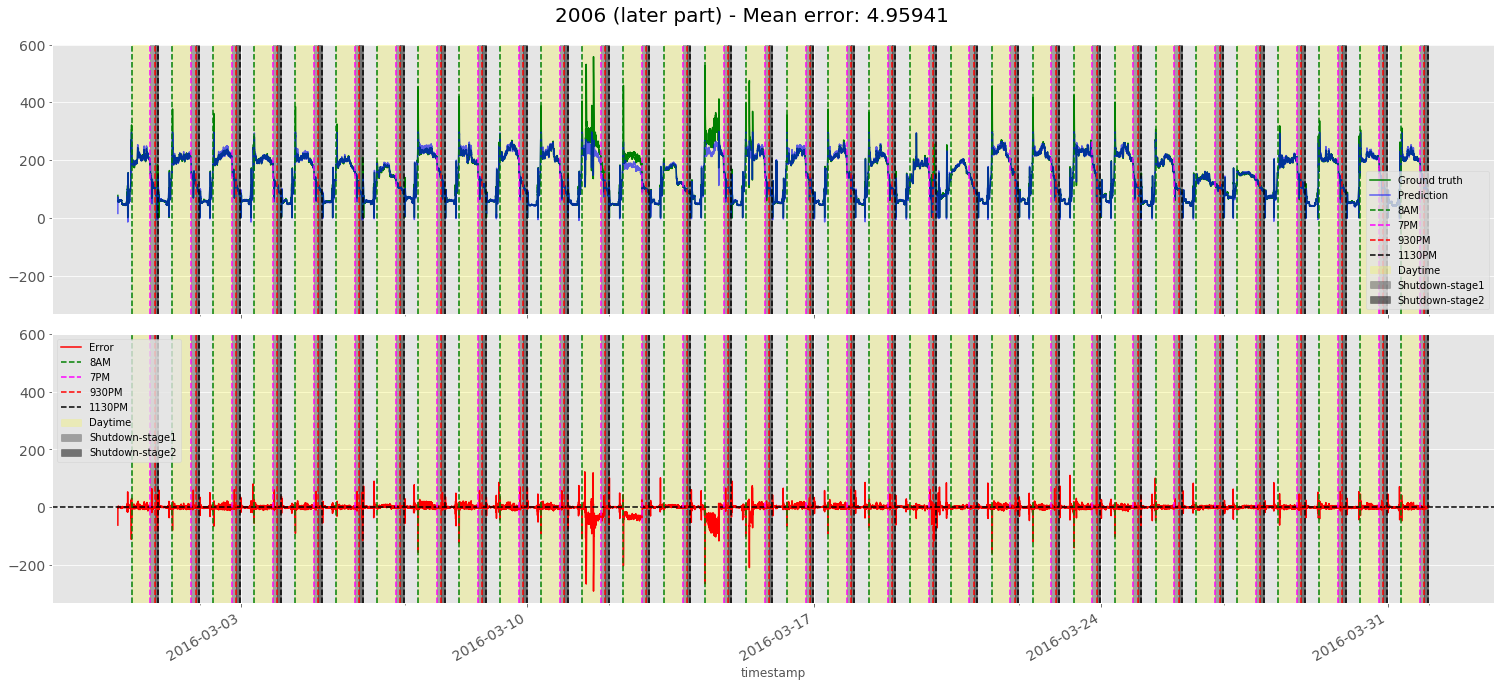

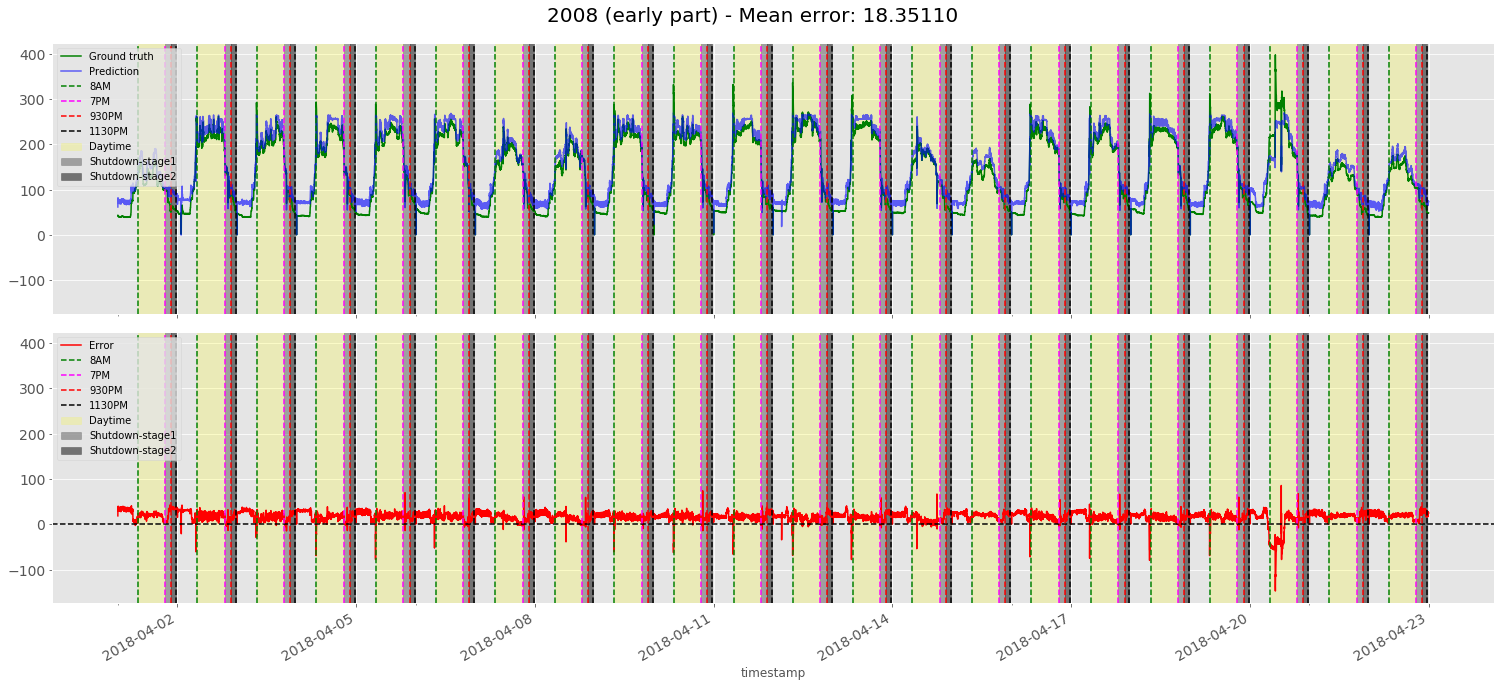

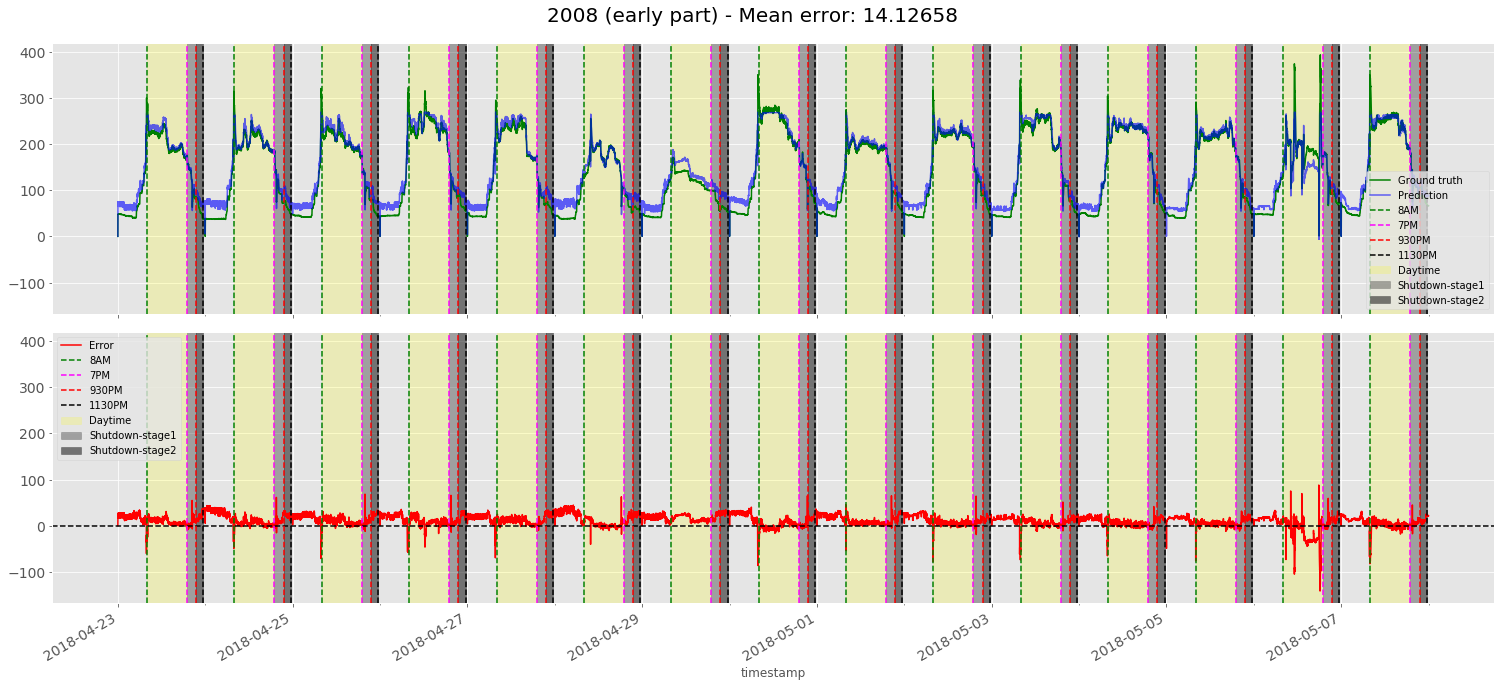

In [142]:
y1_train_pred = xgb.predict(X1_train)
y2_train_pred = xgb.predict(X2_train)
y1_test_pred = xgb.predict(X1_test)
y2_test_pred = xgb.predict(X2_test)

plot_model_error(y1_train, y1_train_pred, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, title="2008 (early part)")

### Plot cumulative error

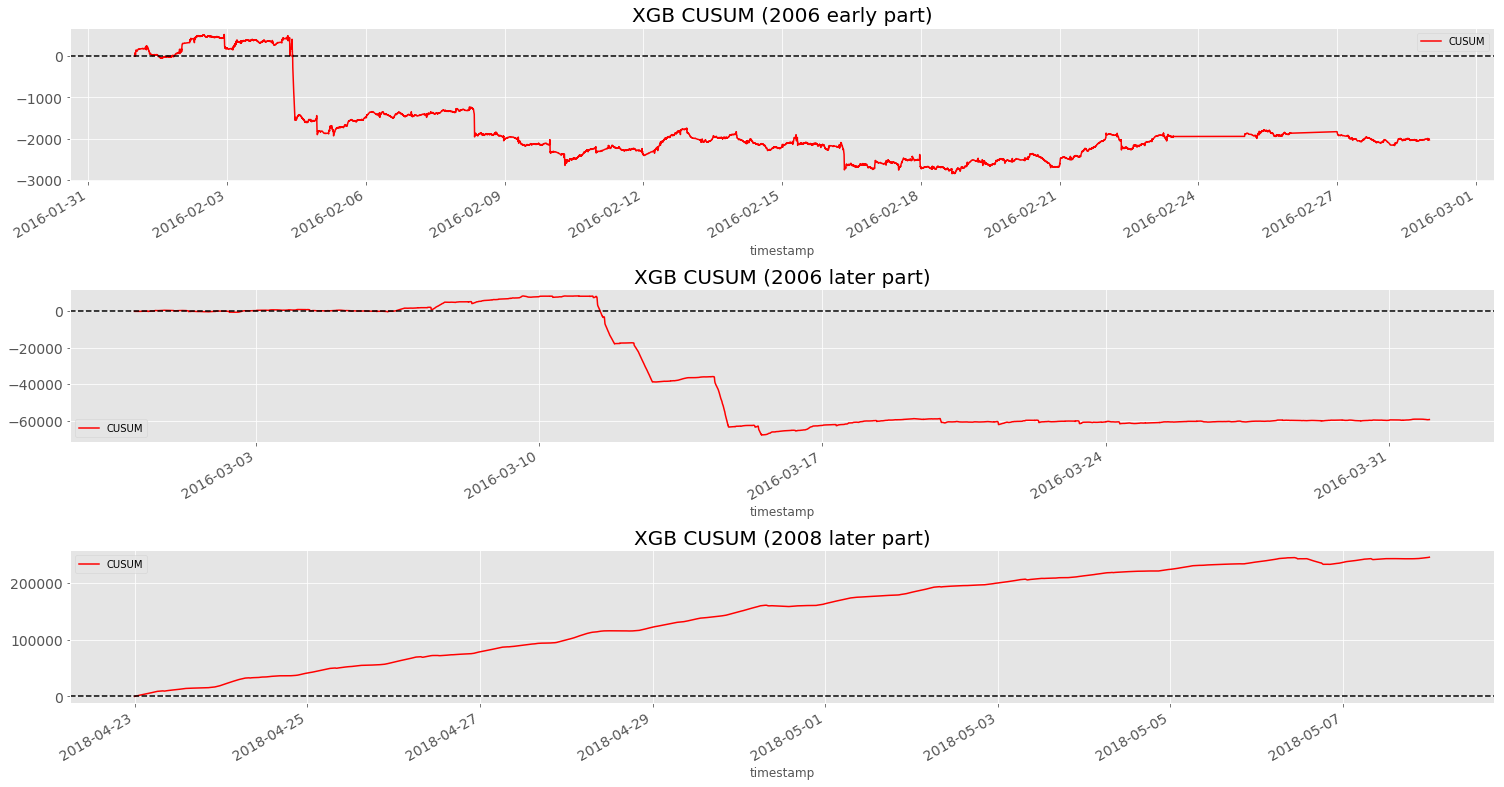

In [144]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "XGB CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "XGB CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "XGB CUSUM (2008 later part)", ax=axes[2])

Interestingly, we see that this XGBoost model also **under predict** the output for the later part of 2006 and **over predict** for the year 2008.

Could the over prediction be a sign that for similar sensor input, the 2008 data corresponding output is **smaller because the system has gotten less efficient?**

## GP

Let's try another sophisticated probabilistic model - [Gaussian Processes](https://sheffieldml.github.io/GPy/). This model is interesting in that it can be extended to handle multi-outputs as well as incorporate time information. It can also produce a measure of its uncertainty along with each prediction.

Here, to handle the large number of data, we reduce the dataset to the first N_TRAIN examples in the sequence and use n_inducing pseudoinputs learned using the Sparse Gaussian Process.

In [45]:
from GPy.models import SparseGPRegression

N_TRAIN = 30000
n_inducing = 2000

dim = X1_train.shape[1]

k_white = GPy.kern.White(input_dim=dim, variance=10.0)
k_matern32 = GPy.kern.Matern32(input_dim=dim, variance=10.0, lengthscale=2000)
# We can add a white noise kernel 
# k = k_matern32 + k_white
k = k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

In [157]:
# gpr.optimize_restarts(num_restarts=5)
# This will take a very long time for large datasets (n ~ 10000)
gpr.optimize()

KeyboardInterrupt caught, calling on_optimization_end() to round things up


KeyboardInterrupt: 

### Plot errors

Note that 2006 (early part) is also the **training** data.

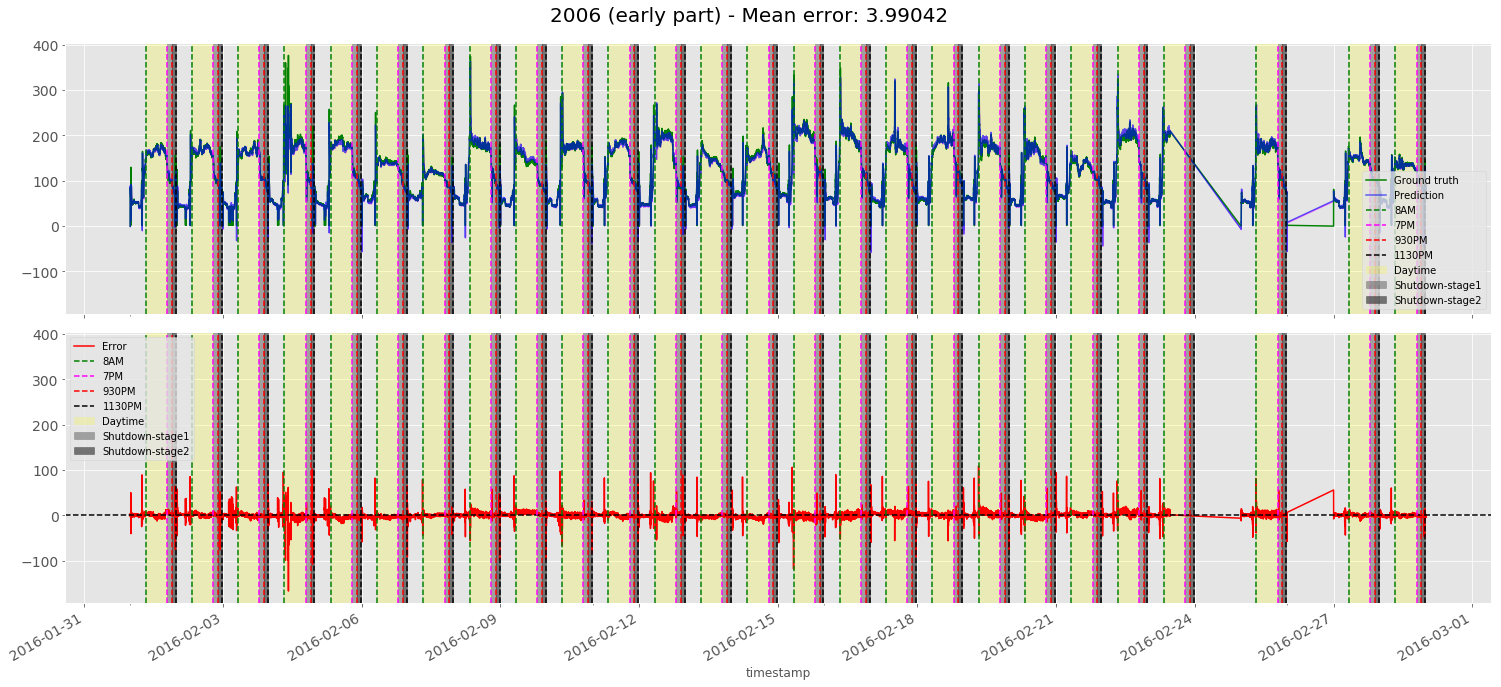

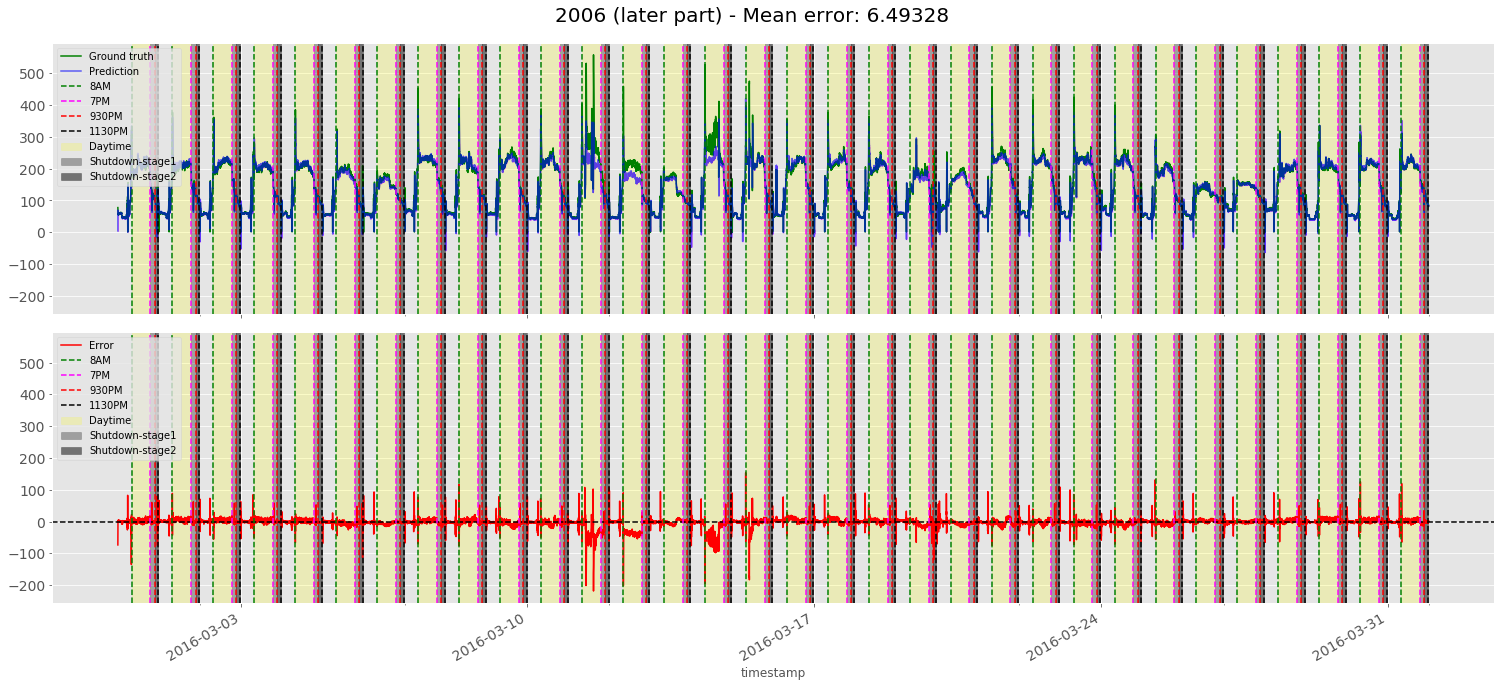

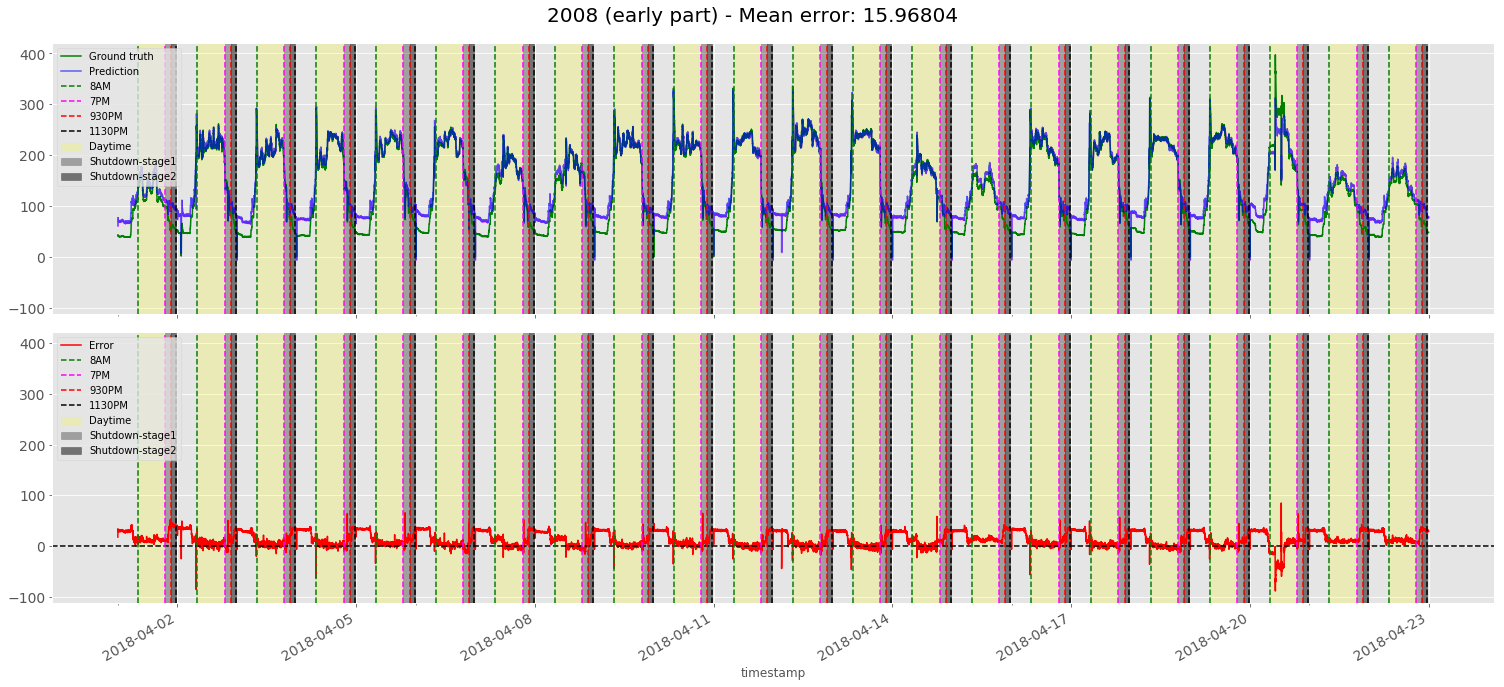

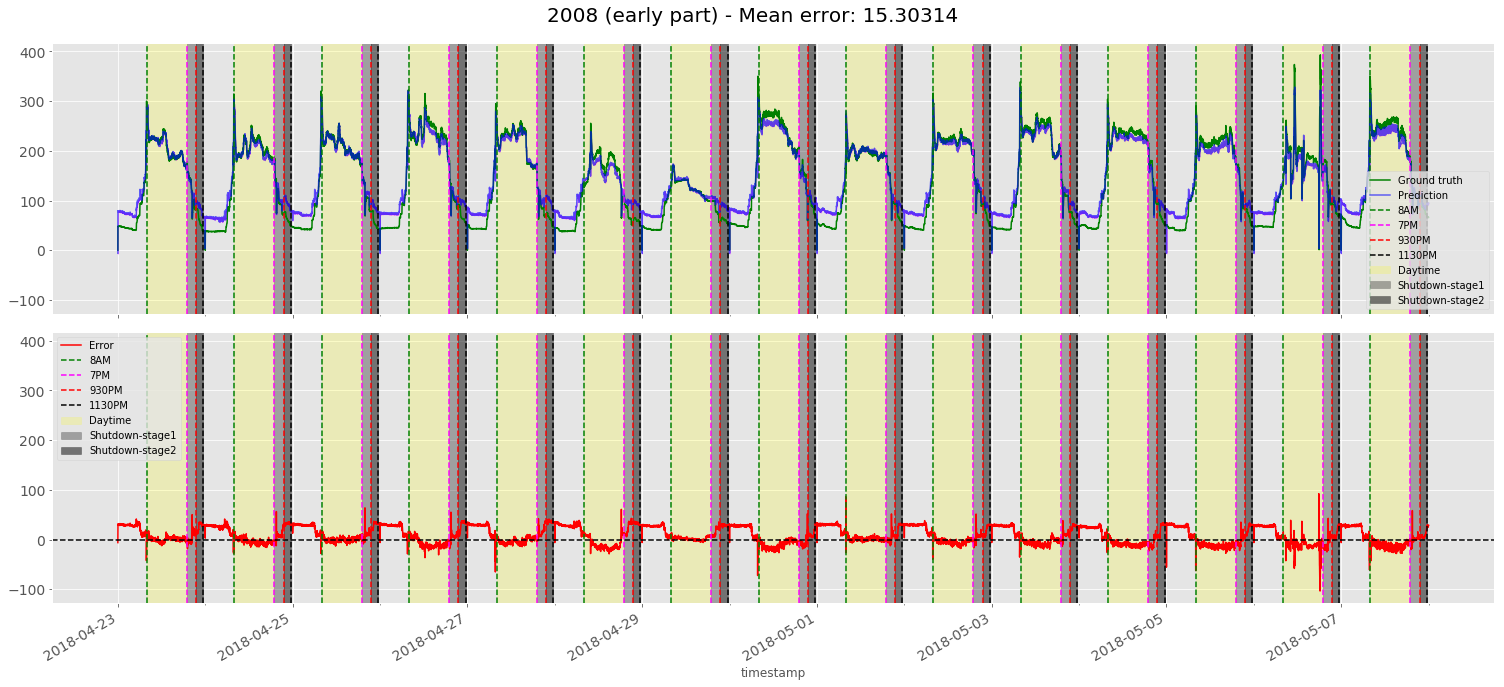

In [46]:
y1_train_pred, y1_train_var = gpr.predict(X1_train.values)
y2_train_pred, y2_train_var = gpr.predict(X2_train.values)
y1_test_pred, y1_test_var = gpr.predict(X1_test.values)
y2_test_pred, y2_test_var = gpr.predict(X2_test.values)

plot_model_error(y1_train, y1_train_pred, y1_train_var, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, y1_test_var, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, y2_train_var, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, y2_test_var, title="2008 (early part)")

### Plot cumulative error

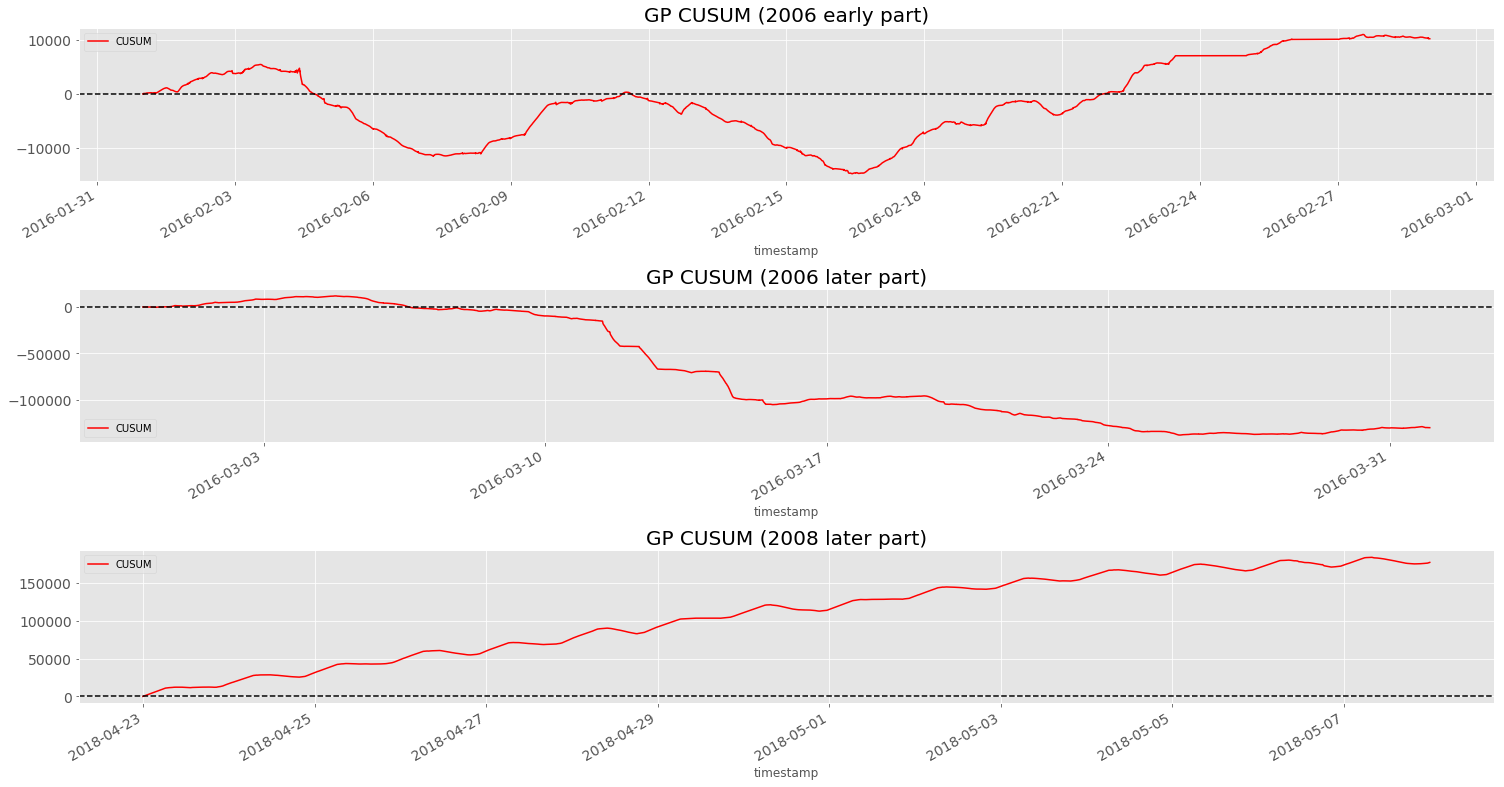

In [48]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "GP CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "GP CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "GP CUSUM (2008 later part)", ax=axes[2])
# print("Target data test error: {:.5f}".format(mean_absolute_error(y2_test, y2_pred)))

Again, just like the linear regression and XGBoost model, we see that the Gaussian Process is also **under predicting** for the 2006 data and **over predicting** for the 2008 data.

However, we should not jump to conclusions here. As mentioned at the top of this document, the predictions are going to be sensitive to hyperparameter settings, so unless we understand the system, we should be careful in our analysis.

## GP with time information

We use an additional kernel to encourage observations close in time and have similar inputs to have similar outputs.

**Future work** can take into account the times the various chillers start to shutdown by using those times as **time-marked data**.

### Create time (in seconds) since midnight (12AM) as feature

In [27]:
from datetime import datetime

def day_elapsed_seconds(dt):
    """Number of seconds elapsed since epoch"""
#     return datetime.timestamp(dt)
    return dt.hour * 3600 + dt.minute * 60 + dt.second

def machine_start_time_seconds(df, threshold=0):
    machine_start = dict()
    for k, g in df.totalkw.groupby(df.index.dayofyear):
        for i, x in g.iteritems():
            if x > threshold:
                machine_start[k] = day_elapsed_seconds(i)
                break
                
    return machine_start 

In [28]:
X1_train = X1_train.assign(time=X1_train.index.to_series().map(day_elapsed_seconds))
X1_test = X1_test.assign(time=X1_test.index.to_series().map(day_elapsed_seconds))

X2_train = X2_train.assign(time=X2_train.index.to_series().map(day_elapsed_seconds))
X2_test = X2_test.assign(time=X2_test.index.to_series().map(day_elapsed_seconds))

In [160]:
display_side_by_side(X1_train.head(1), X2_train.head(1))

chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 loadsys 
 chwsfhdr 
 time 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 2016-02-01 
 0.0 
 30.4664 
 0.0 
 0.0 
 0.0 
 0.0 
 0 
 
 
 
 
 
 
 chwshdr 
 cwrhdr 
 cwshdr 
 cwsfhdr 
 loadsys 
 chwsfhdr 
 time 
 
 
 timestamp 
 
 
 
 
 
 
 
 
 
 
 
 2018-04-01 
 0.0 
 0.0 
 0.0 
 576.223 
 95.6832 
 486.972 
 0

In [29]:
import GPy
from GPy.kern import Matern32
from GPy.kern import RBF

from GPy.models import SparseGPRegression

N_TRAIN = 20000
n_inducing = 1000

dim = X1_train.shape[1]

# k_matern32 = GPy.kern.Matern32(input_dim=dim - 1, variance=5.0, lengthscale=2000, 
#                                active_dims=np.arange(dim - 1))
# k_time = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=5*60, 
#                            active_dims=[dim - 1])

k_matern32 = GPy.kern.Matern32(input_dim=dim - 1, variance=20.0, lengthscale=2000, 
                               active_dims=np.arange(dim - 1))
k_time = GPy.kern.Matern32(input_dim=1, variance=1, lengthscale=120*60, 
                           active_dims=[dim - 1])

# k_time = GPy.kern.RBF(input_dim=1, active_dims=[dim - 1], variance=300, lengthscale=5*60)

# Modulate similarity by only requiring similar inputs around the same time of day to have similar outputs
k = k_time * k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior w

 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.
 /home/hongwei/anaconda3/envs/bca-env/lib/python3.6/site-packages/sklearn/base.py:115: DeprecationWarning:Estimator GpyRegressor modifies parameters in __init__. This behavior is deprecated as of 0.18 and support for this behavior will be removed in 0.20.


Best param: [1672.15423503  644.38526278 1779.97817982   37.38861271]


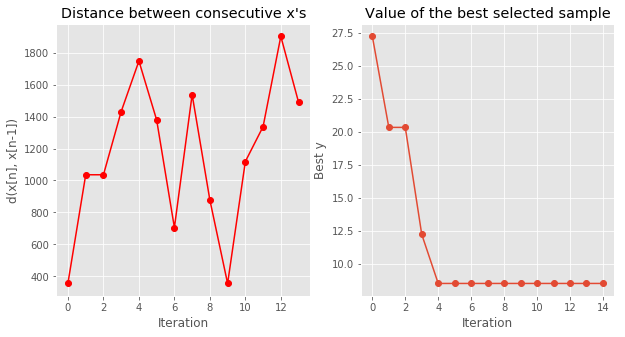

In [23]:
# Pick length scales 1, 2 and variance 1 and 2

import functools
from sklearn.base import BaseEstimator, ClassifierMixin
from GPy.kern import Matern32
from GPy.models import GPRegression, SparseGPRegression

class GpyRegressor(BaseEstimator, ClassifierMixin):
    """Scikit-Learn wrapper for GPyRegressor"""
    
    def __init__(self, lengthscale=1, variance=1, time_lengthscale=1, time_variance=1):
        self.lengthscale = lengthscale,
        self.variance = variance,
        self.time_lengthscale = time_lengthscale,
        self.time_variance = time_variance
                
    def fit(self, X, y):        
        assert X.shape[0] == len(y), "Number of training examples and labels must match."
        
        dim = X.shape[1]
        self.input_dim_ = dim
        
        self.data_kernel_ = Matern32(input_dim=dim - 1, 
                                     lengthscale=self.lengthscale, 
                                     variance=self.variance, 
                                     active_dims=np.arange(dim - 1))
        self.time_kernel_ = Matern32(input_dim=1, 
                                     lengthscale=self.time_lengthscale,
                                     variance=self.time_variance,
                                     active_dims=[dim - 1])        
        self.kernel_ = self.time_kernel_ * self.data_kernel_
                
        self.regressor_ = SparseGPRegression(X=X, 
                                             Y=y.reshape(-1, 1),
                                             kernel=self.kernel_,
                                             num_inducing=1000)
        
#         self.regressor_ = GPRegression(X=X, Y=y.reshape(-1, 1), kernel=self.kernel_) 
        
        return self
    
    def predict(self, X, y=None):        
        y_pred, _ = self.regressor_.predict(X)
        return y_pred

def f_gp(params, X, y, cv):
    params = params[0]
    lengthscale = params[0]
    variance = params[1]
    time_lengthscale = params[2]
    time_variance = params[3]
            
    score = -cross_val_score(GpyRegressor(lengthscale=lengthscale,
                                          variance=variance,
                                          time_lengthscale=time_lengthscale,
                                          time_variance=time_variance),
                             X, y,
                             cv=cv,
                             pre_dispatch=1,
                             scoring=SCORE_TYPE).mean()
    return np.array(score)


N_TRAIN = 20000
N_TIMESERIES_SPLITS = 3

np.random.seed(BO_RAND_STATE)
f = functools.partial(f_gp, 
                      X=X1_train.values[:N_TRAIN], 
                      y=y1_train.values[:N_TRAIN], 
                      cv=TimeSeriesSplit(n_splits=N_TIMESERIES_SPLITS))
gp_domains = [{'name': 'lengthscale', 'type': 'continuous', 'domain': (10, 2e3)},
              {'name': 'variance', 'type': 'continuous', 'domain': (1, 1e3)},
              {'name': 'time_lengthscale', 'type': 'continuous', 'domain': (0.1, 30*60)},
              {'name': 'time_variance', 'type': 'continuous', 'domain': (0.1, 1e2)},
             ]
optimizer = GPyOpt.methods.BayesianOptimization(f=f, 
                                                domain=gp_domains,
                                                acquisition_type='EI', # "LCB"
                                                acquisition_par=0.1,
                                                num_cores=1,
                                                exact_feval=False)

optimizer.run_optimization(max_iter=10)
print("Best param: {}".format(optimizer.x_opt))

optimizer.plot_convergence()

In [24]:
print("Best crossval score: {:.5f} best params: {}".format(optimizer.fx_opt, optimizer.x_opt))

Best crossval score: 8.49493 best params: [1672.15423503  644.38526278 1779.97817982   37.38861271]


In [48]:
import GPy
from GPy.kern import RBF

n_inducing = 1000

best_params = optimizer.x_opt

lengthscale = 2000 #best_params[0]
variance = 20 #best_params[1]
time_lengthscale = 3 * 60 #best_params[2]
time_variance = 1.0 #best_params[3]

dim = X1_train.shape[1]

k_matern32 = GPy.kern.Matern32(input_dim=dim - 1, 
                               variance=variance, 
                               lengthscale=lengthscale, 
                               active_dims=np.arange(dim - 1))

k_time = GPy.kern.Matern32(input_dim=1, 
                           variance=time_variance,
                           lengthscale=time_lengthscale,
                           active_dims=[dim - 1])

# We can also add a white noise kernel to ignore sharp spikes
# k = k_matern32 + k_white

# Modulate similarity by only requiring similar inputs close in time to have same output.
k = k_time * k_matern32

gpr = SparseGPRegression(X=X1_train.values[:N_TRAIN], 
                         Y=y1_train.values[:N_TRAIN].reshape(-1, 1),
                         kernel=k,
                         num_inducing=n_inducing)

### Plot errors

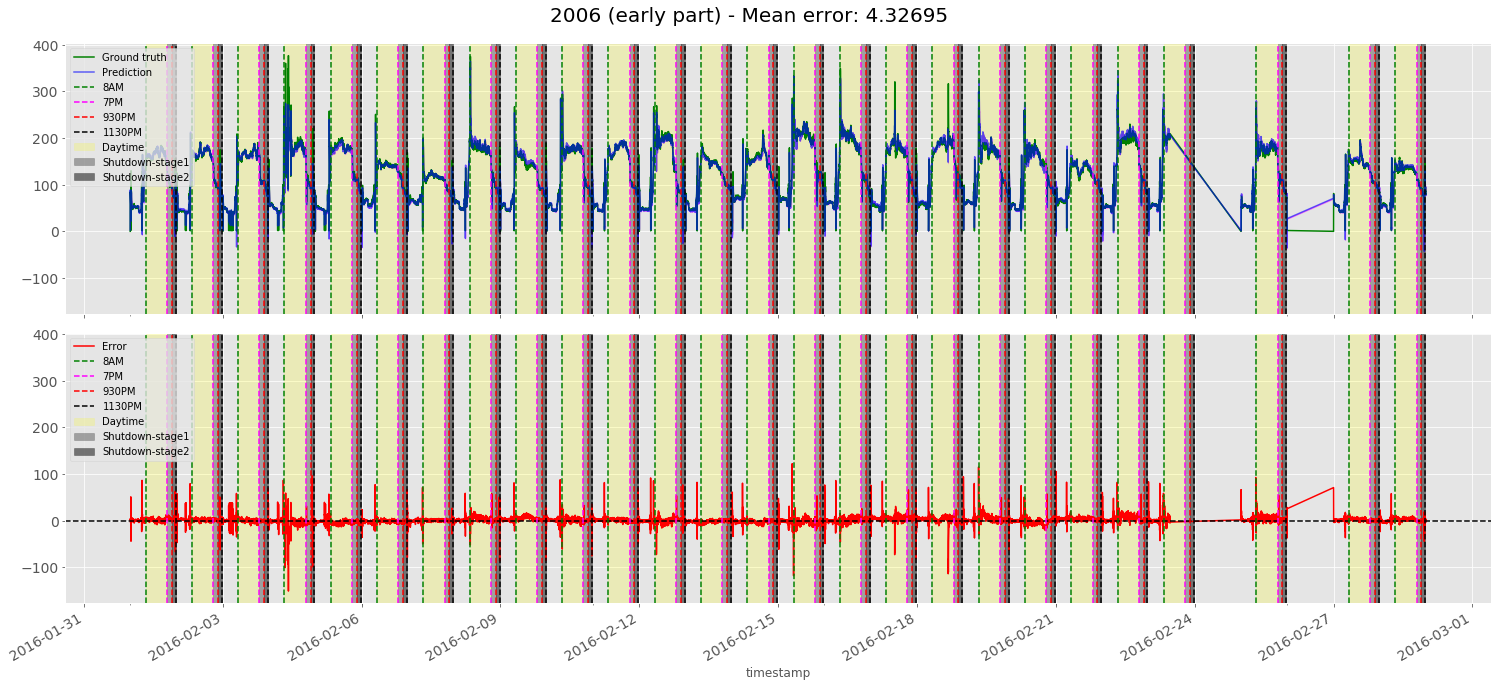

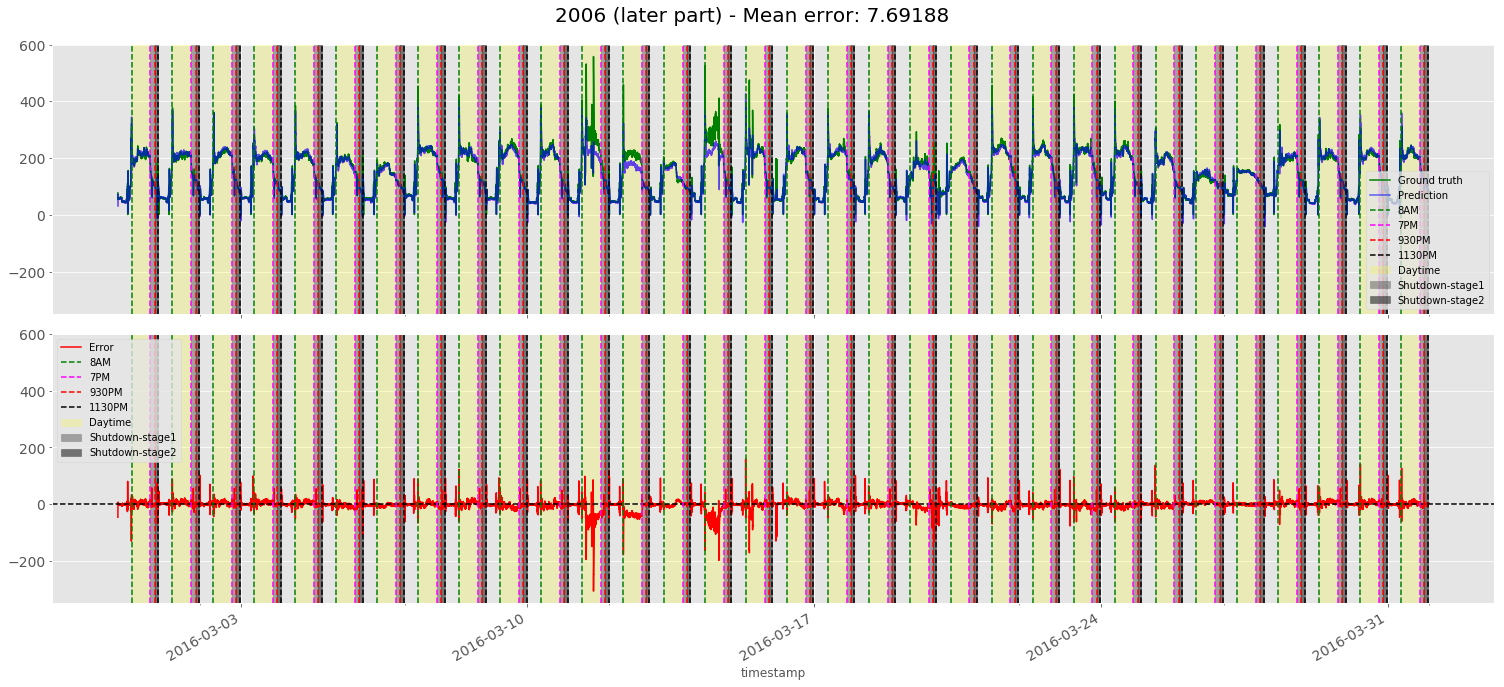

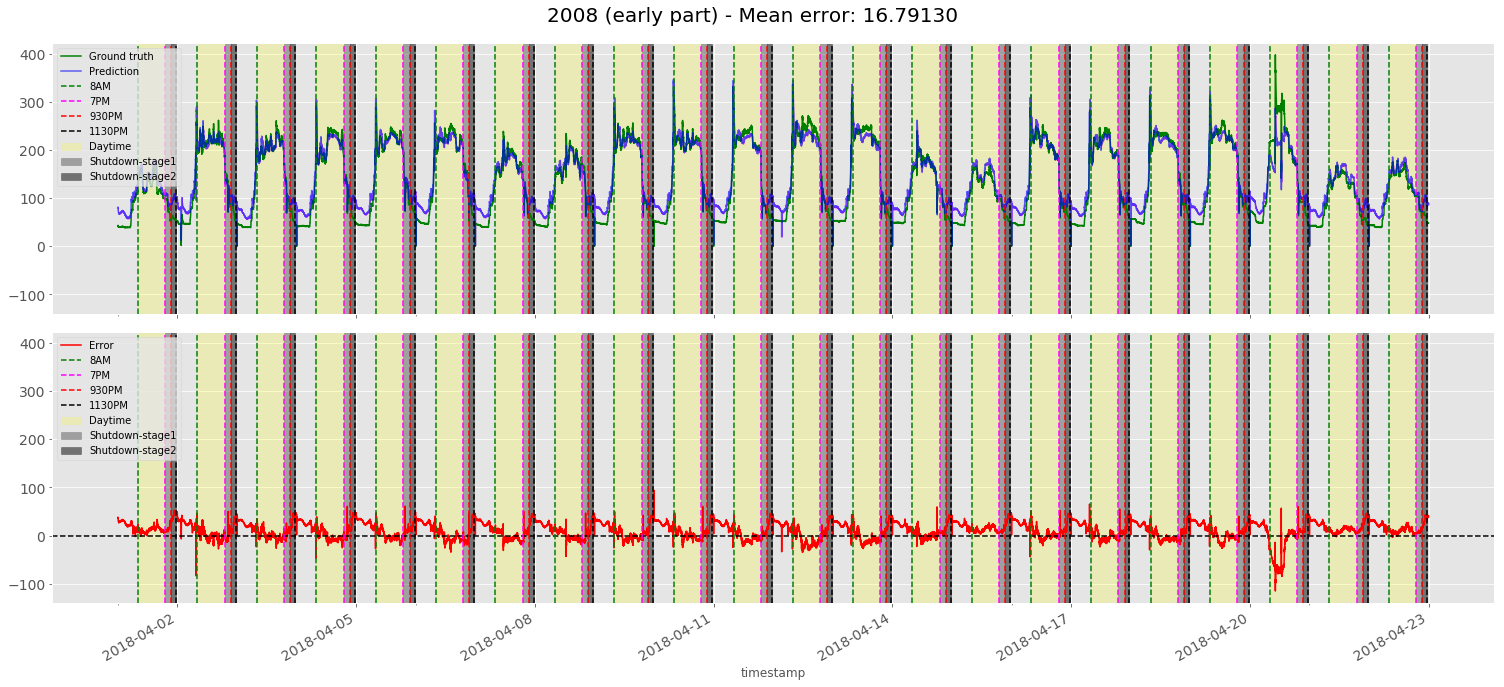

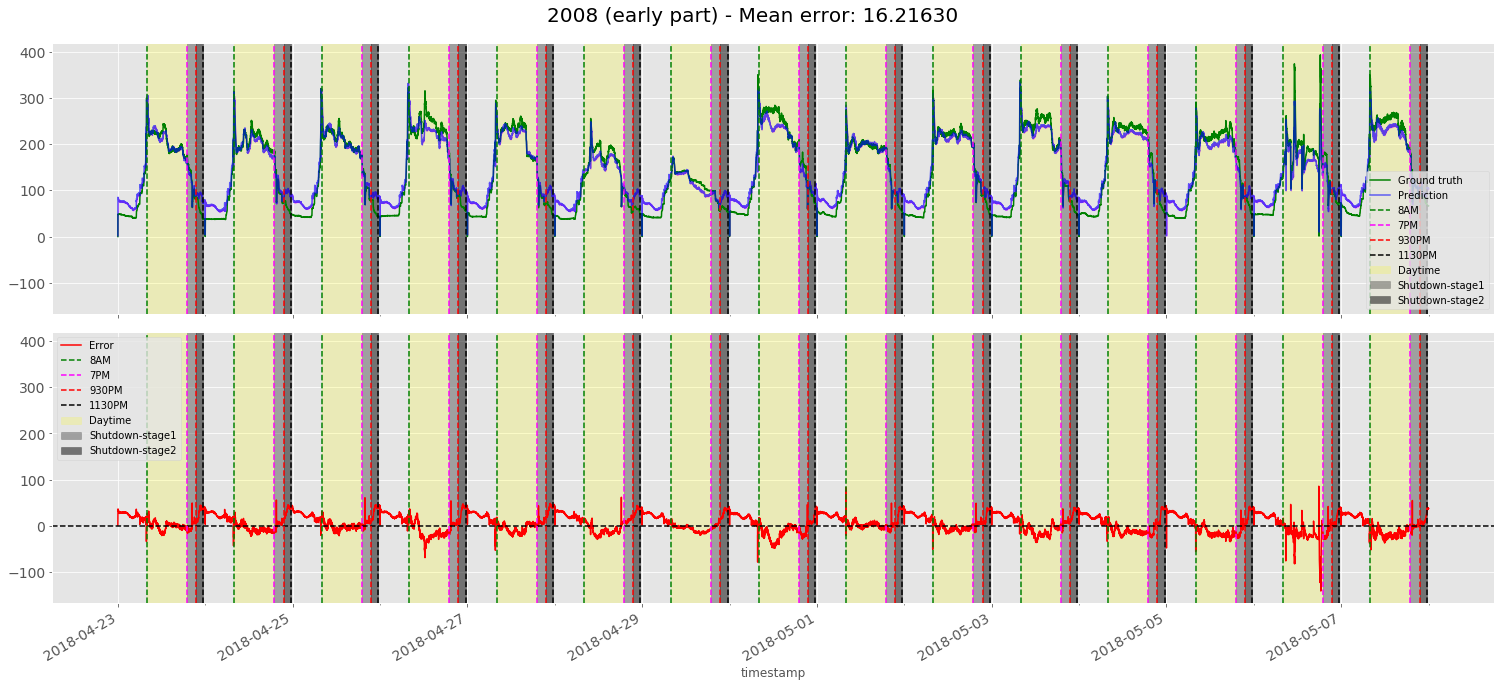

In [30]:
y1_train_pred, y1_train_var = gpr.predict(X1_train.values)
y2_train_pred, y2_train_var = gpr.predict(X2_train.values)
y1_test_pred, y1_test_var = gpr.predict(X1_test.values)
y2_test_pred, y2_test_var = gpr.predict(X2_test.values)

plot_model_error(y1_train, y1_train_pred, pred_variance=y1_train_var, title="2006 (early part)")
plot_model_error(y1_test, y1_test_pred, pred_variance=y1_test_var, title="2006 (later part)")
plot_model_error(y2_train, y2_train_pred, pred_variance=y2_train_var, title="2008 (early part)")
plot_model_error(y2_test, y2_test_pred, pred_variance=y2_test_var, title="2008 (early part)")

Notice that the mean absolute error here is smaller than all of the above models. Using time information to reduce the coupling across time is therefore helpful to improve performance of the model.

### Plot cumulative error

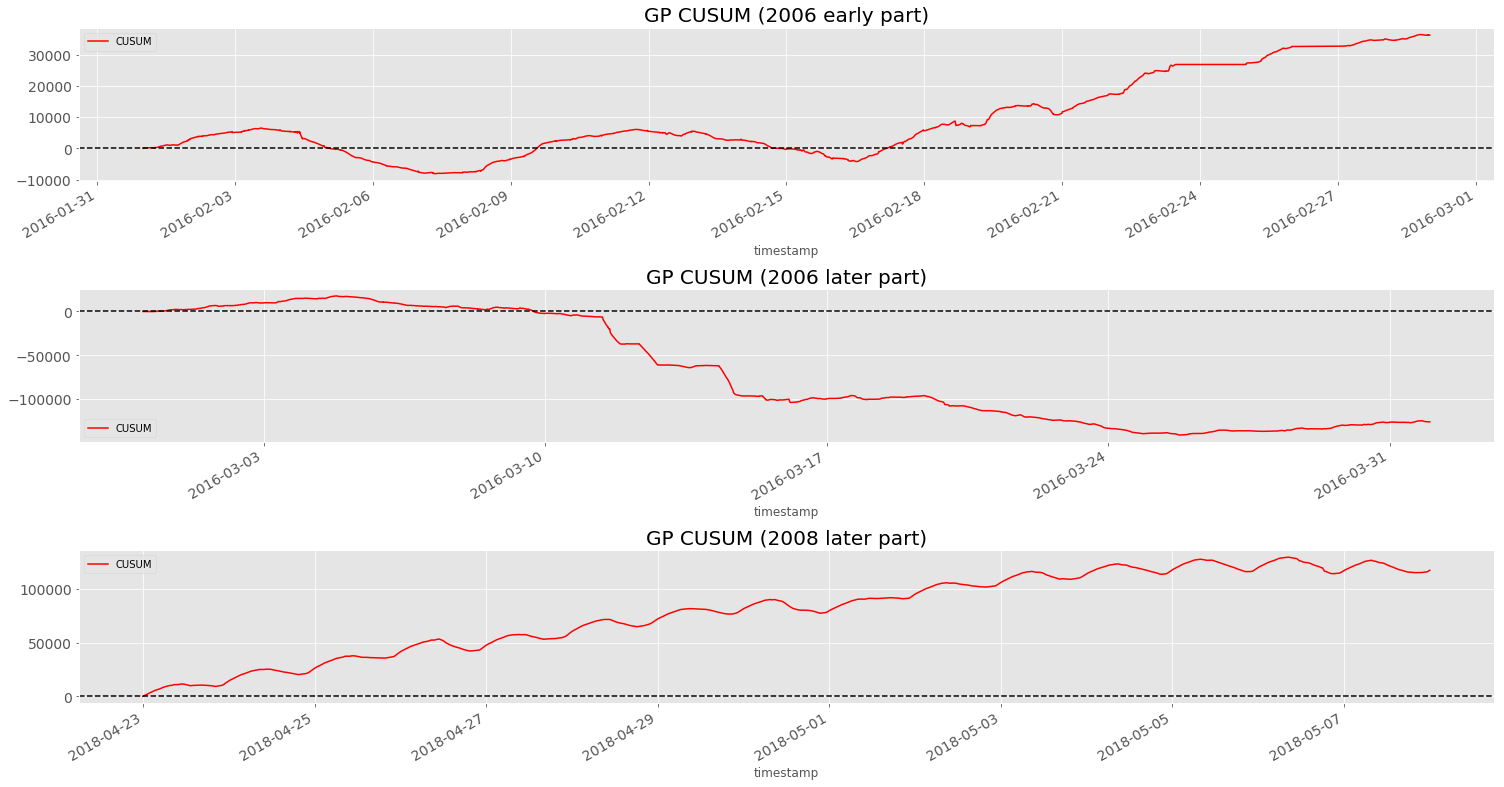

In [31]:
fig, axes = plt.subplots(3, 1, figsize=(21, 12))
plot_cusum(y1_train, y1_train_pred, "GP CUSUM (2006 early part)", ax=axes[0])
plot_cusum(y1_test, y1_test_pred, "GP CUSUM (2006 later part)", ax=axes[1])
plot_cusum(y2_test, y2_test_pred, "GP CUSUM (2008 later part)", ax=axes[2])

## GP with mean function

Use GP to model the residual of a linear regression algorithm.

# Distribution of error over time

We analyze the distribution of the error over time to check if there is some systematic errors in the predictions.

In [132]:
# Group error by time and plot box plots
def plot_error_dist(y, pred, figsize=(15, 18), title=None):
    error = y.ravel() - pred.ravel()
    error = pd.Series(error, index=y.index, name="Error")
    df_error = pd.DataFrame(error)
    
    groups = df_error.groupby(error.index.to_series().dt.hour)
    n_groups = len(groups)
    
    # Find nearest square
    n = int(np.sqrt(n_groups) + 1)
    
    fig, ax = plt.subplots(n, n, figsize=figsize, sharex=True, sharey=True)

    if title is None:
        title = "Error distributed by hour"
    fig.suptitle(title)
    groups.boxplot(ax=ax.ravel()[:n_groups]);

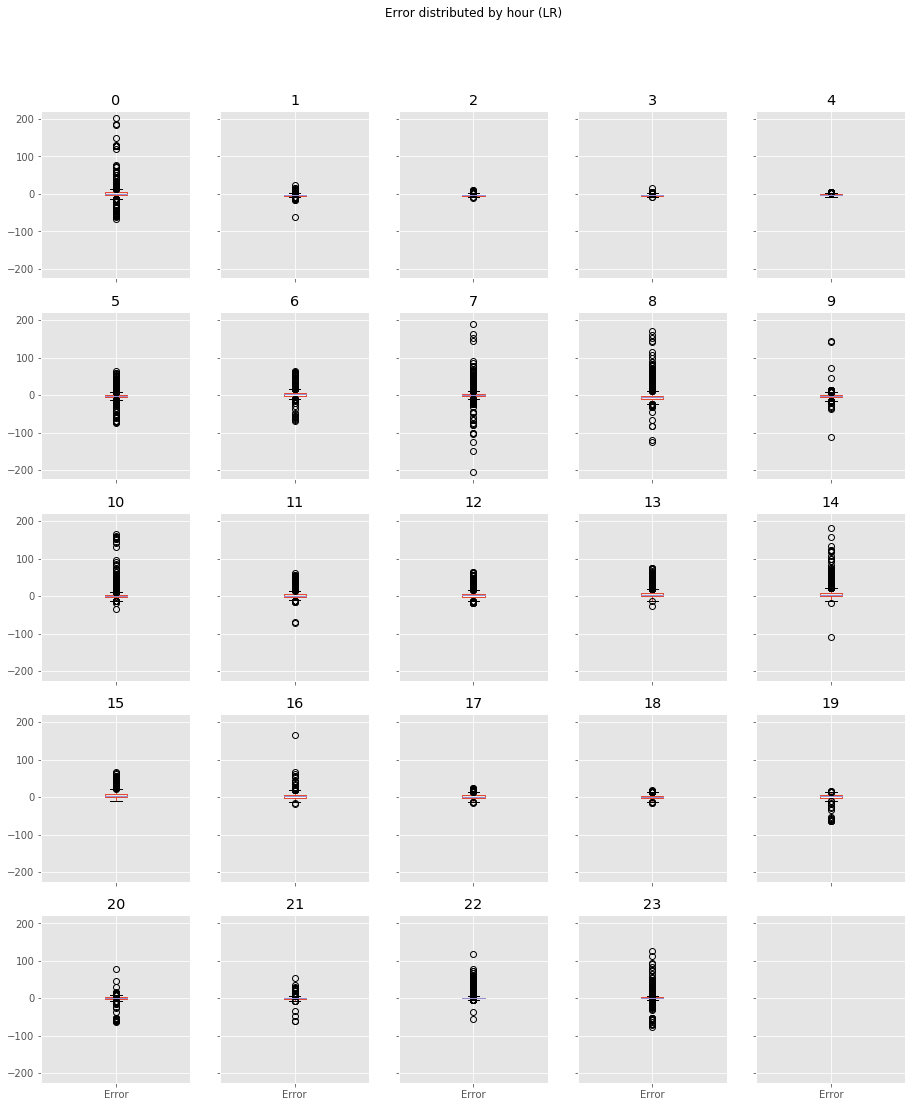

In [137]:
plot_error_dist(y1_test, y1_pred, title="Error distributed by hour (LR)")

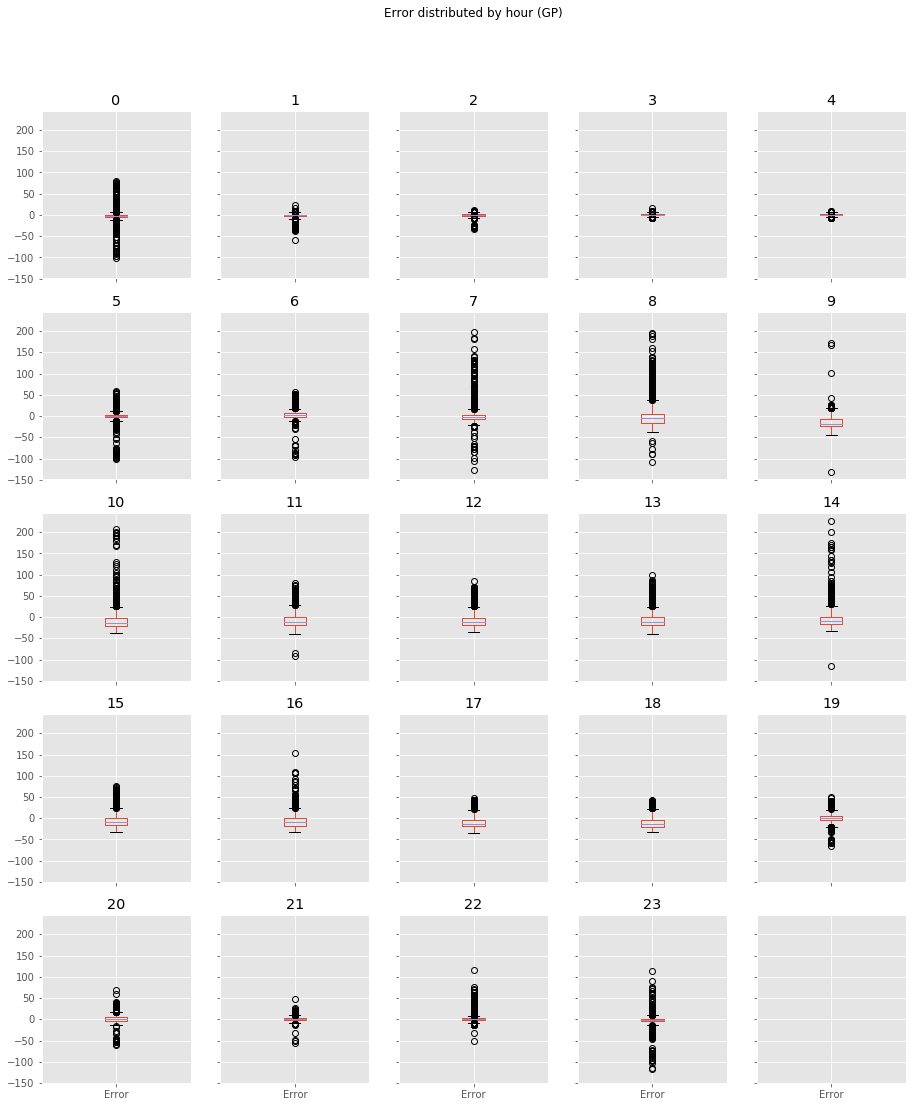

In [133]:
plot_error_dist(y1_test, y1_pred, title="Error distributed by hour (GP)")

---

# Miscellaneous

Code no longer used

Best param: 27.825594022071257


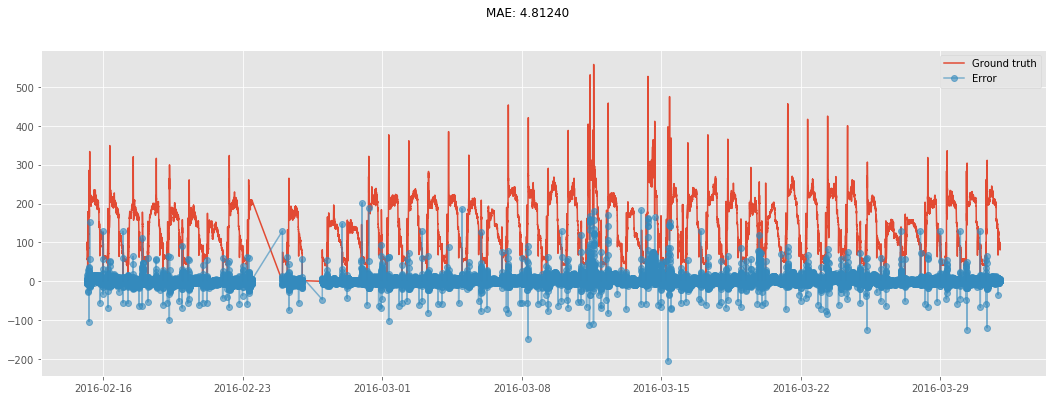

In [240]:
alphas = np.logspace(-3, 5, 10)
ridge_cv = RidgeCV(alphas=alphas, cv=TimeSeriesSplit(n_splits=3))
ridge_cv.fit(X1_train, y1_train)
print("Best param: {}".format(ridge_cv.alpha_))

y1_pred = ridge_cv.predict(X1_test)

mean_error = mean_absolute_error(y1_test, y1_pred)

plt.figure(figsize=(18, 6))
plt.plot(y1_test, label="Ground truth")
plt.plot(y1_test - y1_pred, marker='o', alpha=0.6, label="Error")
plt.legend()
plt.suptitle("MAE: {:.5f}".format(mean_error));

In [206]:
y2_pred = ridge_cv.predict(X2_test)
mean_absolute_error(y2_test, y2_pred)

7.733407180798312

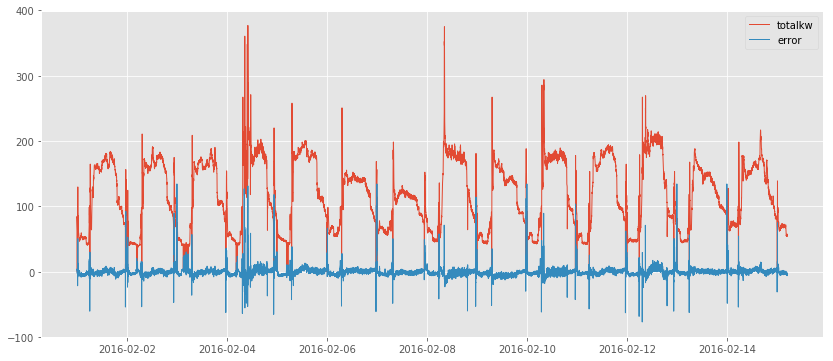

In [136]:
y1_pred = ridge.predict(df1_train)

plt.figure(figsize=(14, 6))
plt.plot(df1_train.index, y1_train, linewidth=1, label="totalkw")
plt.plot(df1_train.index, y1_train - y1_pred, linewidth=1, label="error")
plt.legend()

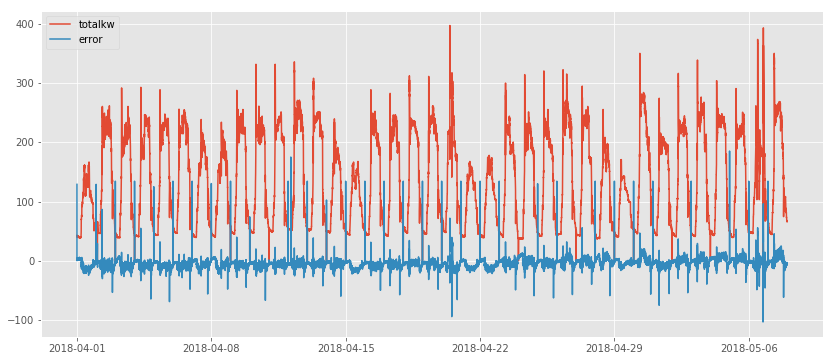

In [137]:
y2_pred = ridge.predict(dfX2)

plt.figure(figsize=(14, 6))
plt.plot(dfX2.index, y2, label="totalkw")
plt.plot(dfX2.index, y2 - y2_pred, label="error")
plt.legend()

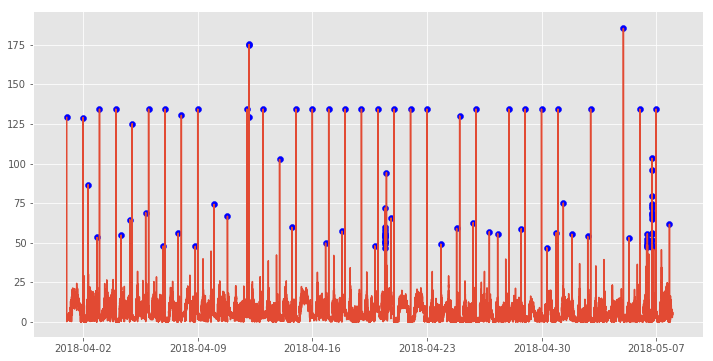

In [174]:
error = np.abs(y2 - y2_pred)
large_errors_idxs = np.argwhere(error > np.max(error) / 4)

plt.figure(figsize=(12, 6))
plt.plot(dfX2.index, error)
plt.scatter(dfX2.index[large_errors_idxs], error[large_errors_idxs], c='blue')

In [194]:
large_errors_times = df2.index[large_errors_idxs]
large_errors = error[large_errors_idxs]

tmp = pd.DataFrame(data=[large_errors_times.flatten(), 
                         large_errors.flatten()]).T
tmp.columns = ["time", "error"]
tmp = tmp.set_index("time")
tmp.index = tmp.index.floor("1H").strftime("%a-%H")
tmp

error
Sun-00  129.055
Mon-00  129.035
Mon-07  86.7322
Mon-20  53.3341
Tue-00  134.372
Wed-00  134.372
Wed-07  54.8495
Wed-20  64.5326
Thu-00  125.151
Thu-19  68.9725
Fri-00  134.372
Fri-21  47.9695
Sat-00  134.372
Sat-19  56.0327
Sun-00  130.422
Sun-20  47.7984
Mon-00  134.372
Tue-00  74.2226
Tue-19   66.736
Thu-00  134.372
Thu-03  129.108
Thu-03  174.939
Thu-03  175.162
Fri-00  134.372
Sat-00  102.586
Sat-17  59.7701
Sun-00  134.372
Mon-00  134.372
Mon-19  49.8089
Tue-00  134.372
...         ...
Wed-19  53.9524
Thu-00  134.372
Sat-00  185.266
Sat-08  53.2771
Sun-00  134.372
Sun-10  48.8418
Sun-11  47.5692
Sun-11  47.9096
Sun-11  55.7396
Sun-11  52.4649
Sun-11   50.436
Sun-11   48.635
Sun-17  103.298
Sun-18  47.4333
Sun-18  55.2843
Sun-18  64.8266
Sun-18  73.3951
Sun-18  74.5192
Sun-18  68.4251
Sun-18  96.2256
Sun-18  69.0658
Sun-18  67.0063
Sun-18  72.1075
Sun-18  79.6011
Sun-18  56.0874
Sun-18  51.8298
Sun-18  47.0288
Sun-18  48.8834
Mon-00  134.372
Mon-19   61.633

[100 rows x 1 columns]

In [195]:
bad_times = pd.DataFrame(data=large_errors_times, columns=["time"])

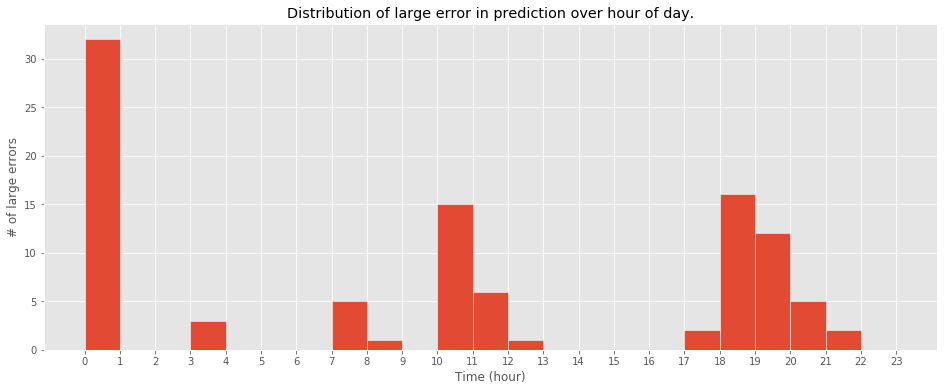

In [196]:
plt.figure(figsize=(16, 6))
bad_times.time.dt.hour.hist(bins=range(24), edgecolor="white")
plt.xlabel("Time (hour)")
plt.ylabel("# of large errors")
plt.title("Distribution of large error in prediction over hour of day.")
plt.xticks(range(24));

In [233]:
bad_times.time.dtype

dtype('<M8[ns]')

In [ ]:
# Group by hour of day and plot boxplot



In [198]:
isinstance(tmp, pd.DataFrame)

True

In [258]:
def plot_errors(y_true, y_pred, time_index):
#     print(y_true.shape, y_pred.shape)
    errors = y_true - y_pred
    
    df = pd.DataFrame(data=errors)
#     df.index = df.index.floor("1H").strftime("%a-%H")
    
    assert(len(y_true) == len(time_index))
    
    df.boxplot(by=time_index)
    
    return df
        
    

In [253]:
dfX2.index.to_series().dt.hour.values

array([ 0,  0,  0, ..., 23, 23, 23])

In [259]:
df_errors = plot_errors(y2, y2_pred, dfX2.index.to_series().dt.hour)
# df_errors.index

TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [240]:
bad_times.time.dtype

dtype('<M8[ns]')

In [243]:
bad_times.time.dtype

dtype('<M8[ns]')

In [245]:
bad_times.time[:3]

0   2018-04-01 00:00:00
1   2018-04-02 00:00:00
2   2018-04-02 07:31:00
Name: time, dtype: datetime64[ns]

In [244]:
df_errors.index[:3]

DatetimeIndex(['2018-04-01 00:00:00', '2018-04-01 00:01:00',
               '2018-04-01 00:02:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [246]:
df_errors.index.dt.hour

AttributeError: 'DatetimeIndex' object has no attribute 'dt'